In [1]:
import numpy as np
import tonic
import tonic.transforms as transforms
from torchvision import transforms as tt
from torchvision.transforms.functional import InterpolationMode
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
from typing import Tuple
from tqdm.notebook import tqdm
from statistics import mean

import snntorch as snn
from snntorch import utils
from snntorch import functional as SF
from snntorch import surrogate

from torchmetrics.classification import MultilabelJaccardIndex, MulticlassJaccardIndex

from collections import defaultdict
import os
import gc

In [2]:

num_bins_per_frame = 8 # Can be changed here - the processing should not affect it, I processed so that each file is 1 frame
framerate = 200 # Don't change unless also changed in EVIMO saving

# Standardized sizes, from EVIMO recording
sensor_size = [640, 480, 2]
input_size = (480, 640)

beta = 0.9

batch_size = 4
num_epochs = 300

num_classes_in_dataset = 25
num_classes_in_output = 2

downscale_factor = 16
output_size = (int(input_size[0]/downscale_factor), int(input_size[1]/downscale_factor))

#output_size = (120, 160) #(480, 640) #(30, 40) # Can be changed

dtype=torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
device

device(type='cuda')

In [ ]:
# TODO: Each getitem from the dataset stays in memory, which limits how many scenes I can pull. Figure out way to get it out of memory

In [3]:
output_size

(30, 40)

In [4]:
class EVIMOMask(Dataset):
    def __init__(self,
                 dirs: list,
                 num_bins_per_frame: int,
                 output_size: Tuple,
                ):
        self.dirs = dirs
        self.num_bins_per_frame = num_bins_per_frame
        self.output_size = output_size

        self.length = 0
        self.lengths = []
        for dir in self.dirs:
            curr_len = np.load(dir + "/length.npy")
            self.length += curr_len
            self.lengths.append(curr_len)

    def find_num_classes_in_dataset():
        self.num_classes_in_dataset = 0
        self.classes = torch.empty((1, ))
        for idx in range(0, len(self)):
            dir, index = self.get_dir_index(idx)

            item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
            mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

            classes = torch.unique(mask, sorted=False)
            self.classes = torch.cat((self.classes, classes), dim=0)

        self.classes = torch.unique(self.classes)
        self.num_classes_in_dataset = int(self.classes.max()) + 1

    def find_num_occurrences_for_each_class(self):
        num_occurrences = defaultdict(lambda: 0)
        
        for idx in range(0, len(self)):
            dir, index = self.get_dir_index(idx)
            item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
            
            mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)
            mask = tt.functional.resize(mask, self.output_size, antialias=True, interpolation=InterpolationMode.NEAREST_EXACT)

            for object_class in mask.unique():
                num_occurrences[object_class.item()] += 1

        return num_occurrences

    def get_dir_index(self, index):
        curr_idx_sum = 0
        for i, length in enumerate(self.lengths):
            #print(index, length, curr_idx_sum)
            if curr_idx_sum <= index < curr_idx_sum + length:
                dir = self.dirs[i]
                index -= curr_idx_sum
                break
            curr_idx_sum += length
                

        return dir, index

    def __getitem__(self, index):
        #print(f"Getting idx {index}")
        dir, index = self.get_dir_index(index)
        #print(dir, index)
        
        item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()

        events = np.asarray(item["events"])

        #print(events)

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame),
                                        
                                      ])


        #print(transformed_events)
        events = torch.from_numpy(frame_transform(events)).to(dtype)

        #events = tt.functional.resize(events, (int(input_size[0]/4), int(input_size[1]/4)), interpolation=InterpolationMode.NEAREST_EXACT)

        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

        #mask = torch.nn.functional.one_hot(mask, num_classes_in_dataset=num_classes_in_dataset).transpose(1, 3).transpose(2, 3) # Conversion into Batch, Channels, H, W

        # Downsize the mask.
        mask = tt.functional.resize(mask, self.output_size, antialias=True, interpolation=InterpolationMode.NEAREST_EXACT)


        if num_classes_in_output != num_classes_in_dataset:
            if num_classes_in_output == 2:
                mask = torch.where(mask == 24.0, 1, 0)
            if num_classes_in_output == 3:
                mask = torch.where((mask == 9.0) | (mask == 22.0), 1, mask)
                mask = torch.where((mask != 1) & (mask != 0), 2, mask)
        
        return events, mask.squeeze().to(dtype)#resized_mask.squeeze()

    def get_original_mask(self, index):
        dir, index = self.get_dir_index(index)
        
        item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)
        return mask

    def __len__(self) -> int:
        return self.length # - self.start_idx

    # def get_item(self, index):
    #     item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
    #     return item


In [5]:
# dirs = ["./data/EVIMO/left_cam/scene13_test5",
#        "./data/EVIMO/left_cam/scene14_test3",
#        "./data/EVIMO/left_cam/scene15_test1"]

processed_scene_dir = "./data/EVIMO/EVIMO/tom_processed/"
post_dir = "/samsung_mono/ground_truth_000000/"

dirs = [processed_scene_dir + x + post_dir for x in os.listdir(processed_scene_dir)]

#dirs.remove(processed_scene_dir + ".ipynb_checkpoints" + post_dir)
#dirs.remove(processed_scene_dir + "scene13_dyn_test_01" + post_dir)
#dirs.remove(processed_scene_dir + "scene14_dyn_test_00" + post_dir)

dirs = dirs[0:int(len(dirs)/2)]


In [6]:
dirs

['./data/EVIMO/EVIMO/tom_processed/scene14_dyn_test_00/samsung_mono/ground_truth_000000/',
 './data/EVIMO/EVIMO/tom_processed/scene10_dyn_train_01/samsung_mono/ground_truth_000000/',
 './data/EVIMO/EVIMO/tom_processed/scene10_dyn_train_03/samsung_mono/ground_truth_000000/',
 './data/EVIMO/EVIMO/tom_processed/scene15_dyn_test_04/samsung_mono/ground_truth_000000/',
 './data/EVIMO/EVIMO/tom_processed/scene9_dyn_train_02/samsung_mono/ground_truth_000000/']

In [7]:
dataset = EVIMOMask(dirs=dirs, output_size=output_size, num_bins_per_frame=num_bins_per_frame)

In [8]:
dataset.get_dir_index(2164)

('./data/EVIMO/EVIMO/tom_processed/scene10_dyn_train_03/samsung_mono/ground_truth_000000/',
 221)

In [32]:
len(dataset), len(dataset)/2

(3920, 1960.0)

In [31]:
dataset.find_num_occurrences_for_each_class()

defaultdict(<function __main__.EVIMOMask.find_num_occurrences_for_each_class.<locals>.<lambda>()>,
            {0: 3918,
             5: 392,
             6: 1845,
             9: 2951,
             22: 3917,
             24: 1913,
             11: 618,
             14: 827,
             23: 474,
             8: 1437,
             26: 1031,
             13: 1080,
             25: 1030,
             27: 1000,
             28: 925,
             15: 367,
             10: 94,
             16: 94,
             17: 94,
             18: 94,
             20: 94,
             19: 58,
             12: 12})

In [11]:
bins, mask = dataset[500]
bins.shape

torch.Size([8, 1, 480, 640])

In [12]:
mask.unique()

tensor([0., 1.])

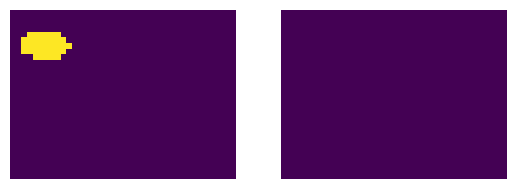

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=1)
axes.ravel()[0].imshow(mask.tolist())
axes.ravel()[0].set_axis_off()
axes.ravel()[1].imshow(torch.where(mask == 24.0, 1, 0).tolist())
axes.ravel()[1].set_axis_off()

In [14]:
spike_grad = surrogate.fast_sigmoid()

loss_fn = SF.ce_rate_loss() #nn.CrossEntropyLoss() # #  #SF.ce_max_membrane_loss() # count loss bad

In [15]:
device

device(type='cuda')

In [16]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # 240x320
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.lif1 = snn.Leaky(beta=beta)

        # 120x160
        self.conv2 = nn.Conv2d(4, 8, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.lif2 = snn.Leaky(beta=beta)

        # 60x80
        self.conv3 = nn.Conv2d(8, 4, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(2)
        self.lif3 = snn.Leaky(beta=beta)

        # 30x40
        self.conv4 = nn.Conv2d(4, 8, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(2)
        self.lif4 = snn.Leaky(beta=beta)

        # 15x20
        self.conv5 = nn.Conv2d(8, 8, kernel_size=5, padding=2)
        self.pool5 = nn.MaxPool2d(2)
        self.lif5 = snn.Leaky(beta=beta)
        
        # 30x40
        self.upconv = nn.ConvTranspose2d(8, num_classes_in_output, kernel_size=2, stride=2)
        #self.unpool2 = nn.MaxUnpool2d(2)
        self.lifout = snn.Leaky(beta=beta)

    
    def forward(self, data):
        out_mem = self.lifout.init_leaky()
        
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        spk_rec = []
        mem_rec = []


        data = data.transpose(0, 1)
        #print(data.shape)
        for step in range(0, num_bins_per_frame):
            
            x = data[step]
            #print(x.shape)

            x = self.pool1(self.conv1(x))
            spk, mem1 = self.lif1(x, mem1)
            
            x = self.pool2(self.conv2(spk))
            spk, mem2 = self.lif2(x, mem2)
            
            x = self.pool3(self.conv3(spk))
            #print(x.shape, mem3.shape)
            spk, mem3 = self.lif3(x, mem3)
            #print(spk.shape, mem3.shape)
    
            x = self.pool4(self.conv4(spk))
            spk, mem4 = self.lif4(x, mem4)
    
            x = self.pool5(self.conv5(spk))
            spk, mem5 = self.lif5(x, mem5)
            
    
            x = self.upconv(spk)
            spk, out_mem = self.lifout(x, out_mem)

            spk_rec.append(spk)
            mem_rec.append(out_mem)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

In [17]:
model = Model().to(device)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.008, betas=(0.9, 0.999))
#optimizer = torch.optim.Adam(model.parameters(), lr=0.002, betas=(0.9, 0.999))

In [19]:
# def forward_pass(data):
#     mem_rec = []
#     spk_rec = []
#     utils.reset(model)  # resets hidden states for all LIF neurons in net
    
#     data = data.transpose(0, 1) # num_steps, batch_size, C, H, W
    
#     for step in range(num_bins_per_frame):
#       spk_out, mem_out = model(data[step])
#       spk_rec.append(spk_out)
#       mem_rec.append(mem_out)

#     return torch.stack(spk_rec), torch.stack(mem_rec)

In [20]:
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [21]:
bins, masks = next(iter(trainloader))

In [22]:
# (torch.Size([4, 8, 1, 120, 160]), torch.Size([4, 30, 40]))
bins.shape, masks.shape

(torch.Size([4, 8, 1, 480, 640]), torch.Size([4, 30, 40]))

In [23]:
masks.unique()

tensor([0., 1.])

In [24]:
def compare_masks(dataset, index, time_step, showonlydiff=False):
    data, mask = dataset[index]
    data = data.to(device).to(torch.float)
    
    data = data.reshape(1, 8, 1, 480, 640)
    #print(data.shape)
    
    spk_rec, mem_rec = model(data)

    output_mask = spk_rec[time_step].squeeze().argmax(dim=0)

    print(output_mask.shape, mask.shape)
    #mask = mask.argmax(dim=0)

    

    if not showonlydiff or output_mask.count_nonzero() > 0:
        fig, axes = plt.subplots(ncols=2, nrows=1)
        axes.ravel()[0].imshow(output_mask.tolist())
        axes.ravel()[0].set_title("Model Generated")
        axes.ravel()[0].set_axis_off()
        axes.ravel()[1].imshow(mask.tolist())
        axes.ravel()[1].set_title("Original")
        axes.ravel()[1].set_axis_off()

        plt.show()
            

    return output_mask, mask

torch.Size([30, 40]) torch.Size([30, 40])


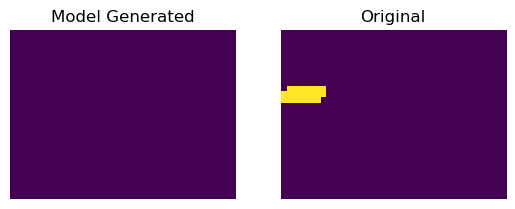

In [25]:
_, _ = compare_masks(dataset, index=0, time_step=0)

In [26]:
240*320

76800

In [27]:
1e-4

0.0001

In [28]:
#model = torch.load("./88_epoch_binary_seg.pth").to(device)

Epoch 0:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.1574, 0.0073], device='cuda:0')
IDX: 1718, time_step: 0
torch.Size([30, 40]) torch.Size([30, 40])


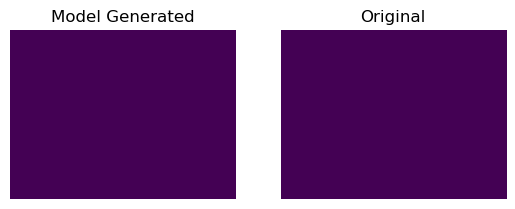

torch.Size([30, 40]) torch.Size([30, 40])


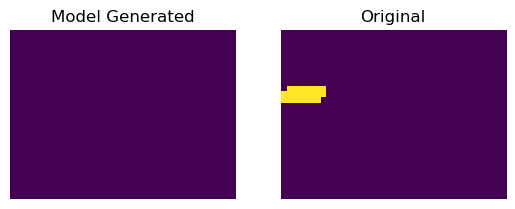

Epoch 1:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.1145, 0.0082], device='cuda:0')
IDX: 762, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


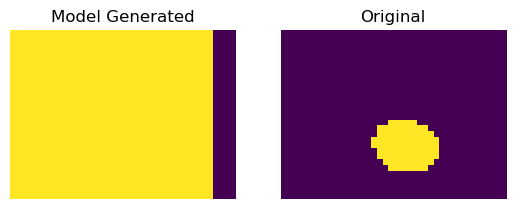

torch.Size([30, 40]) torch.Size([30, 40])


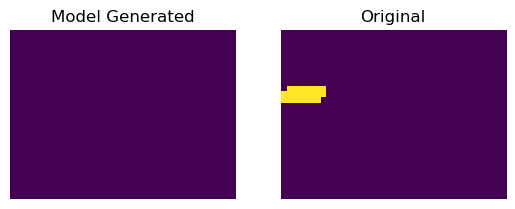

Epoch 2:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0640, 0.0093], device='cuda:0')
IDX: 168, time_step: 2
torch.Size([30, 40]) torch.Size([30, 40])


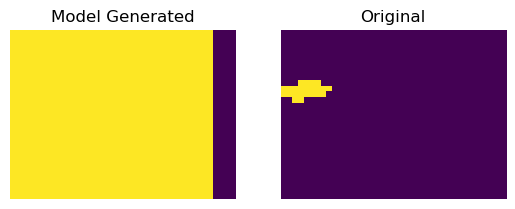

torch.Size([30, 40]) torch.Size([30, 40])


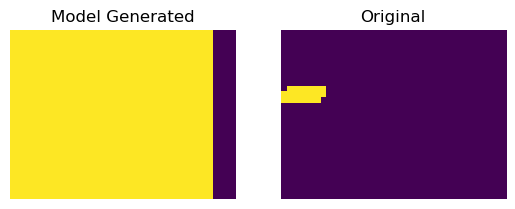

Epoch 3:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0593, 0.0094], device='cuda:0')
IDX: 17, time_step: 2
torch.Size([30, 40]) torch.Size([30, 40])


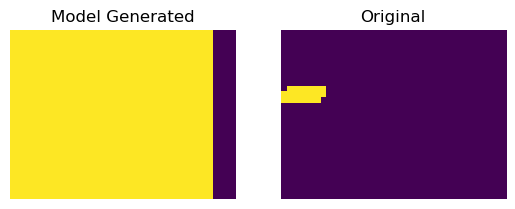

torch.Size([30, 40]) torch.Size([30, 40])


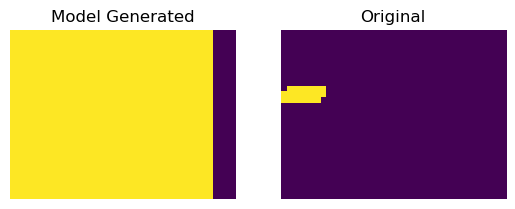

Epoch 4:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0593, 0.0094], device='cuda:0')
IDX: 3132, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


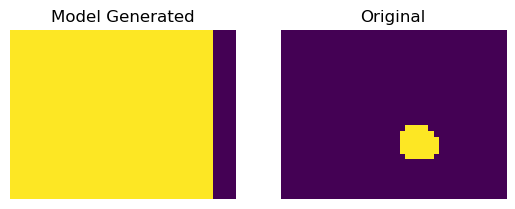

torch.Size([30, 40]) torch.Size([30, 40])


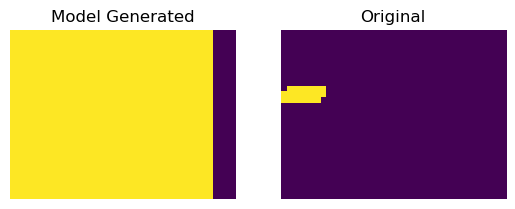

Epoch 5:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0593, 0.0094], device='cuda:0')
IDX: 2541, time_step: 2
torch.Size([30, 40]) torch.Size([30, 40])


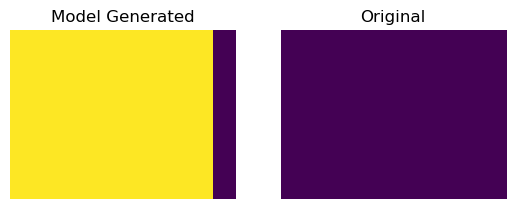

torch.Size([30, 40]) torch.Size([30, 40])


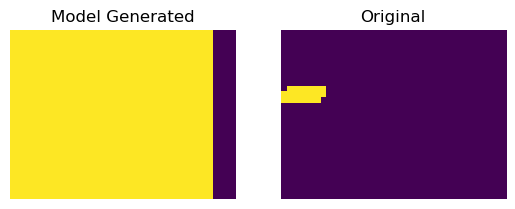

Epoch 6:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0587, 0.0094], device='cuda:0')
IDX: 2202, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


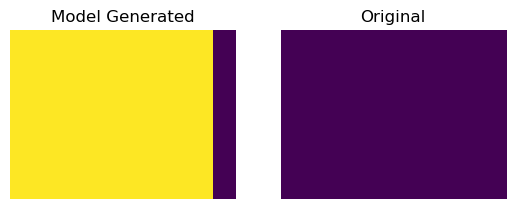

torch.Size([30, 40]) torch.Size([30, 40])


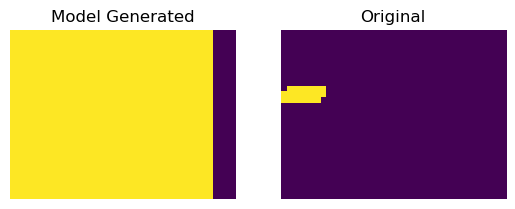

Epoch 7:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0593, 0.0094], device='cuda:0')
IDX: 1967, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


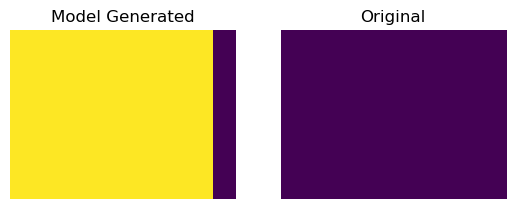

torch.Size([30, 40]) torch.Size([30, 40])


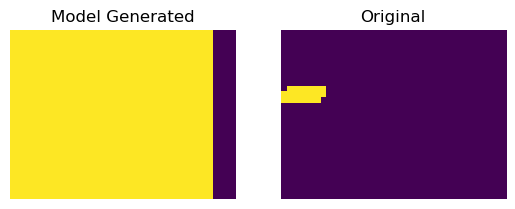

Epoch 8:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0592, 0.0094], device='cuda:0')
IDX: 1675, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


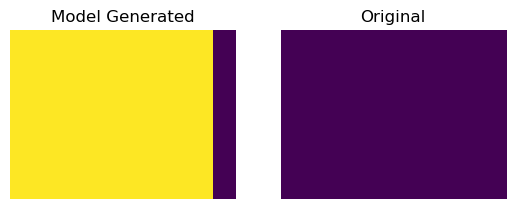

torch.Size([30, 40]) torch.Size([30, 40])


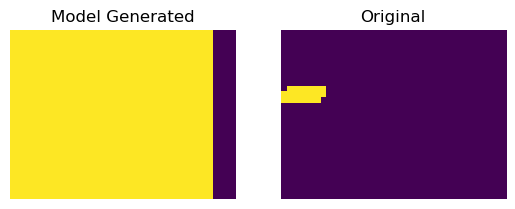

Epoch 9:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0594, 0.0094], device='cuda:0')
IDX: 3268, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


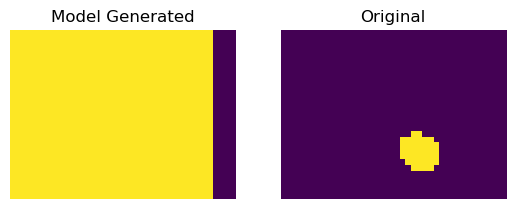

torch.Size([30, 40]) torch.Size([30, 40])


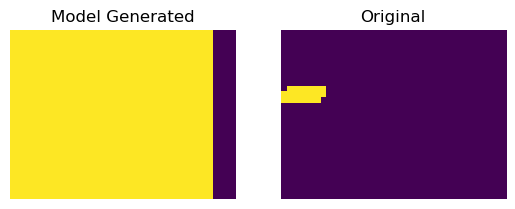

Epoch 10:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.4565, 0.0013], device='cuda:0')
IDX: 1432, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


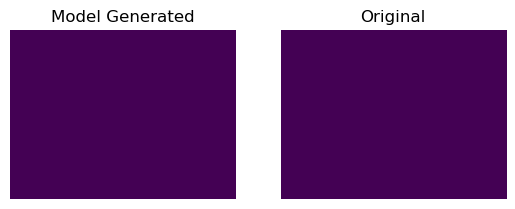

torch.Size([30, 40]) torch.Size([30, 40])


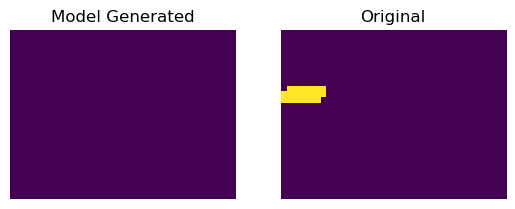

Epoch 11:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.5000, 0.0000], device='cuda:0')
IDX: 397, time_step: 2
torch.Size([30, 40]) torch.Size([30, 40])


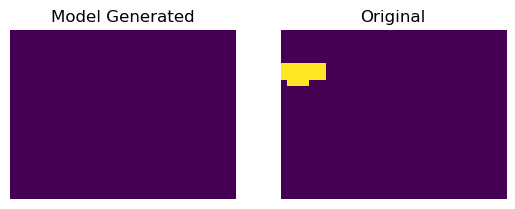

torch.Size([30, 40]) torch.Size([30, 40])


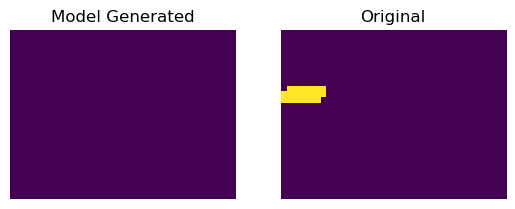

Epoch 12:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.5000, 0.0000], device='cuda:0')
IDX: 1749, time_step: 0
torch.Size([30, 40]) torch.Size([30, 40])


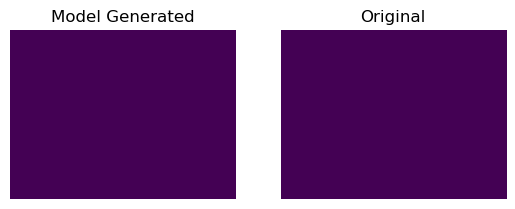

torch.Size([30, 40]) torch.Size([30, 40])


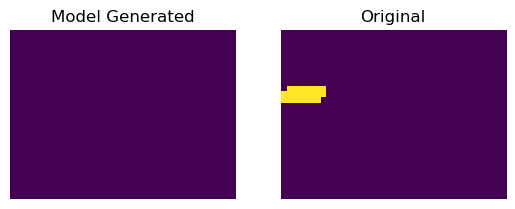

Epoch 13:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.5000, 0.0000], device='cuda:0')
IDX: 809, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


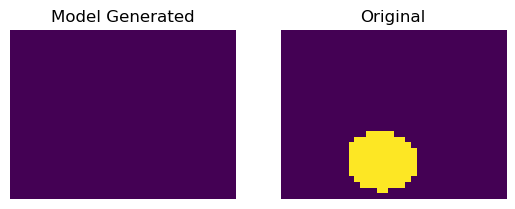

torch.Size([30, 40]) torch.Size([30, 40])


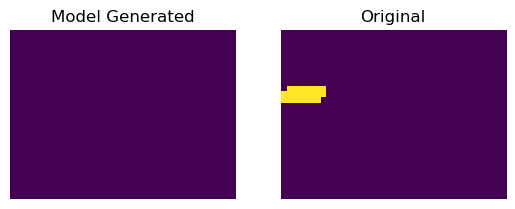

Epoch 14:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([4.9951e-01, 8.0692e-05], device='cuda:0')
IDX: 3821, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


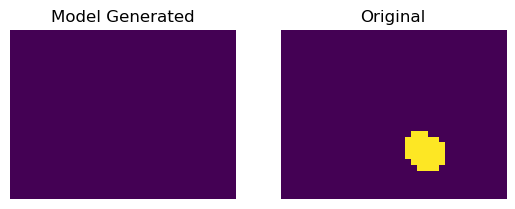

torch.Size([30, 40]) torch.Size([30, 40])


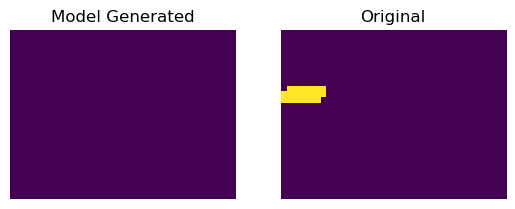

Epoch 15:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.1920, 0.0040], device='cuda:0')
IDX: 1407, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


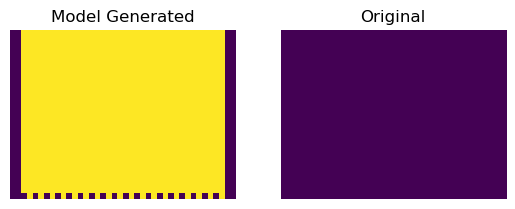

torch.Size([30, 40]) torch.Size([30, 40])


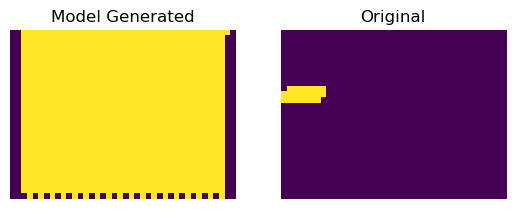

Epoch 16:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0596, 0.0090], device='cuda:0')
IDX: 3314, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


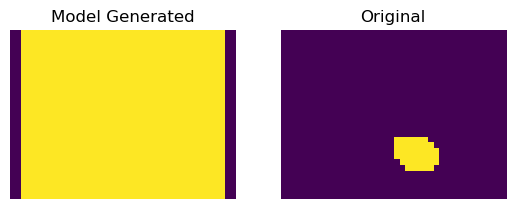

torch.Size([30, 40]) torch.Size([30, 40])


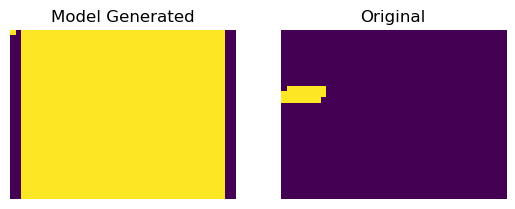

Epoch 17:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0535, 0.0091], device='cuda:0')
IDX: 1652, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


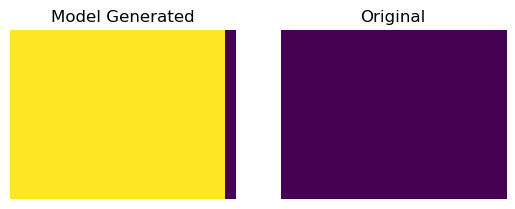

torch.Size([30, 40]) torch.Size([30, 40])


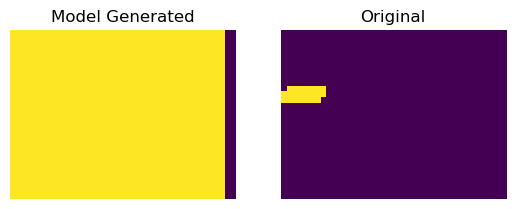

Epoch 18:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 2553, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


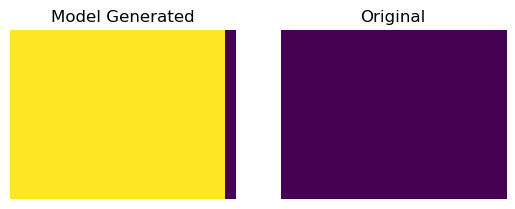

torch.Size([30, 40]) torch.Size([30, 40])


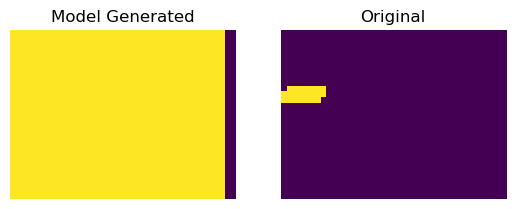

Epoch 19:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.4207, 0.0037], device='cuda:0')
IDX: 3361, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


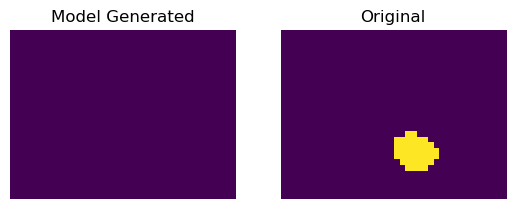

torch.Size([30, 40]) torch.Size([30, 40])


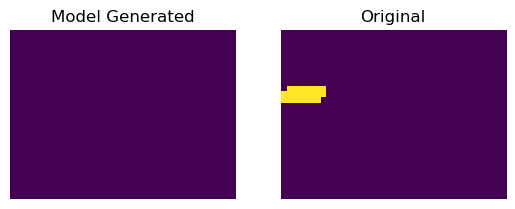

Epoch 20:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([5.0001e-01, 2.3916e-05], device='cuda:0')
IDX: 3595, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


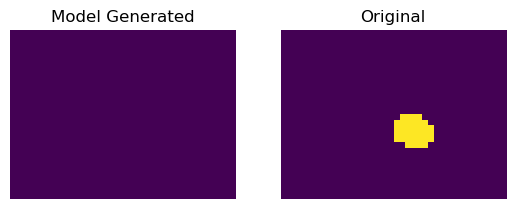

torch.Size([30, 40]) torch.Size([30, 40])


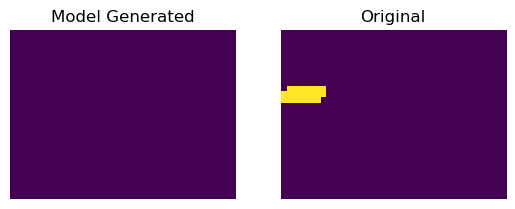

Epoch 21:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([5.0001e-01, 3.5077e-05], device='cuda:0')
IDX: 3827, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


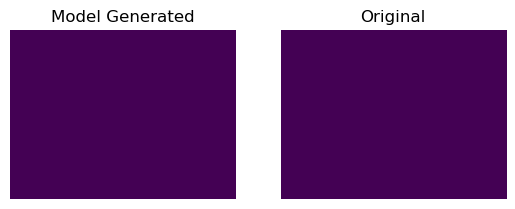

torch.Size([30, 40]) torch.Size([30, 40])


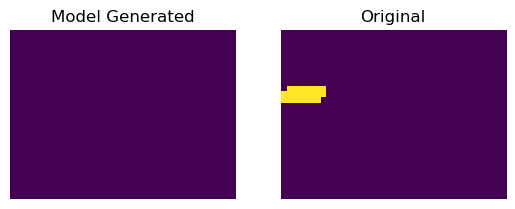

Epoch 22:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([5.0001e-01, 3.8265e-05], device='cuda:0')
IDX: 151, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


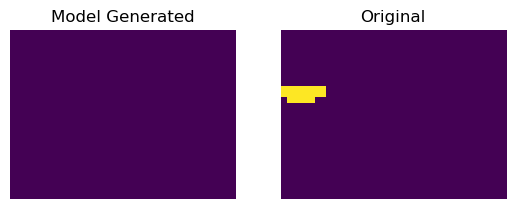

torch.Size([30, 40]) torch.Size([30, 40])


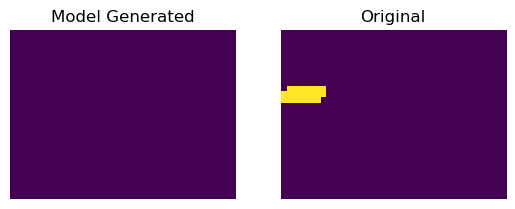

Epoch 23:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([5.0001e-01, 3.3482e-05], device='cuda:0')
IDX: 3384, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


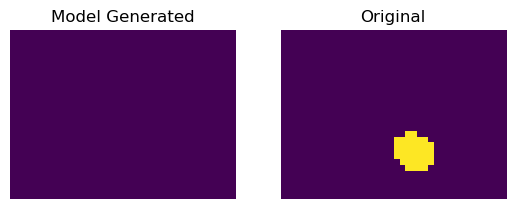

torch.Size([30, 40]) torch.Size([30, 40])


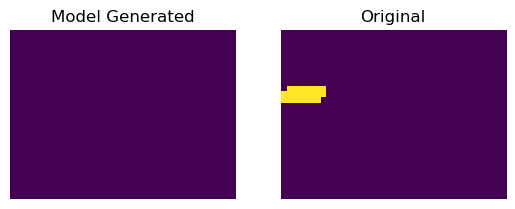

Epoch 24:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([5.0001e-01, 3.1250e-05], device='cuda:0')
IDX: 1132, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


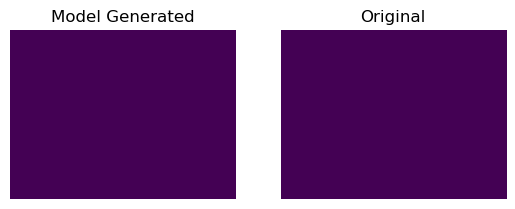

torch.Size([30, 40]) torch.Size([30, 40])


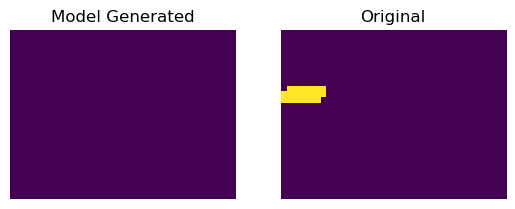

Epoch 25:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([4.9769e-01, 2.3979e-05], device='cuda:0')
IDX: 1211, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


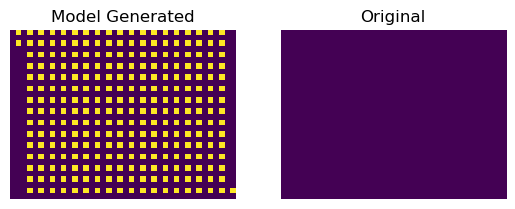

torch.Size([30, 40]) torch.Size([30, 40])


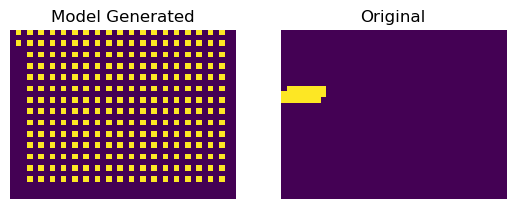

Epoch 26:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([4.9878e-01, 8.3593e-05], device='cuda:0')
IDX: 84, time_step: 0
torch.Size([30, 40]) torch.Size([30, 40])


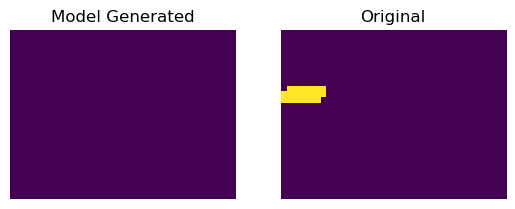

torch.Size([30, 40]) torch.Size([30, 40])


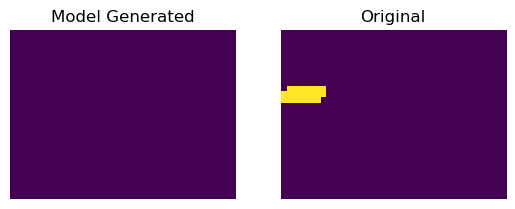

Epoch 27:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.3081, 0.0039], device='cuda:0')
IDX: 3044, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


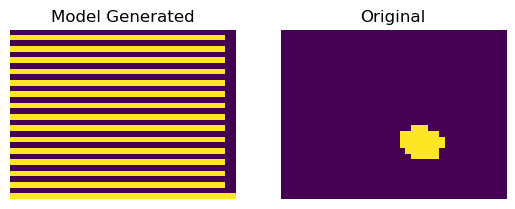

torch.Size([30, 40]) torch.Size([30, 40])


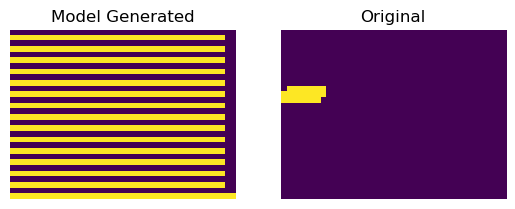

Epoch 28:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.2665, 0.0059], device='cuda:0')
IDX: 3915, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


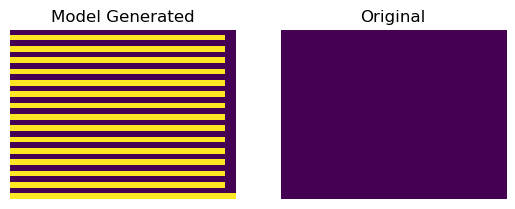

torch.Size([30, 40]) torch.Size([30, 40])


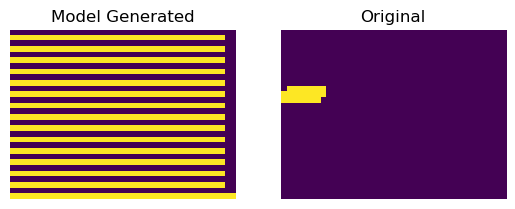

Epoch 29:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.2211, 0.0071], device='cuda:0')
IDX: 3874, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


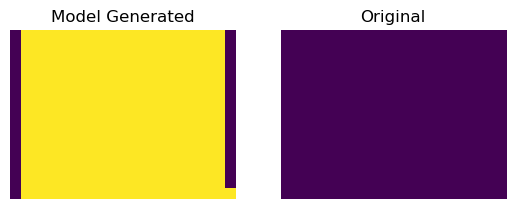

torch.Size([30, 40]) torch.Size([30, 40])


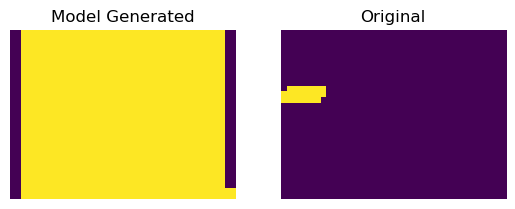

Epoch 30:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0459, 0.0090], device='cuda:0')
IDX: 1089, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


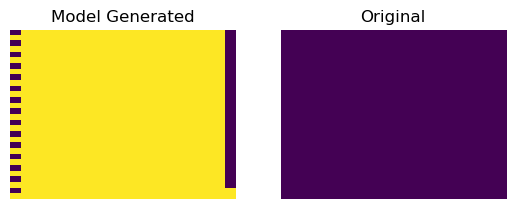

torch.Size([30, 40]) torch.Size([30, 40])


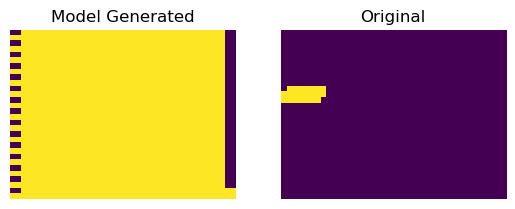

Epoch 31:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0392, 0.0090], device='cuda:0')
IDX: 680, time_step: 2
torch.Size([30, 40]) torch.Size([30, 40])


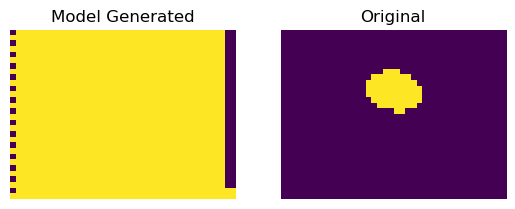

torch.Size([30, 40]) torch.Size([30, 40])


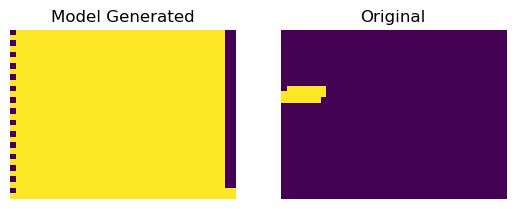

Epoch 32:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0330, 0.0091], device='cuda:0')
IDX: 1367, time_step: 0
torch.Size([30, 40]) torch.Size([30, 40])


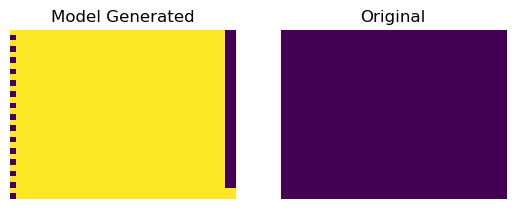

torch.Size([30, 40]) torch.Size([30, 40])


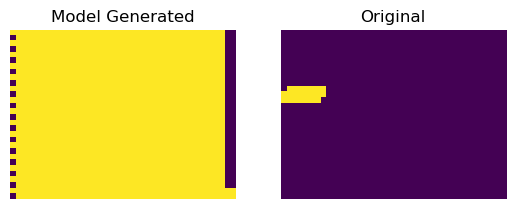

Epoch 33:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0386, 0.0091], device='cuda:0')
IDX: 299, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


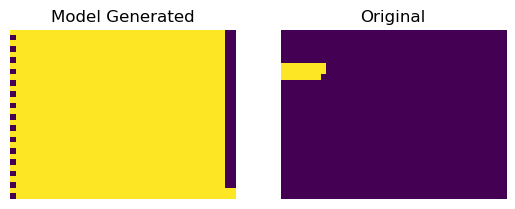

torch.Size([30, 40]) torch.Size([30, 40])


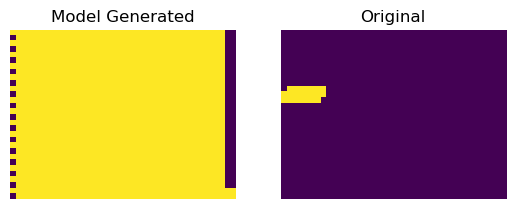

Epoch 34:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0328, 0.0091], device='cuda:0')
IDX: 328, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


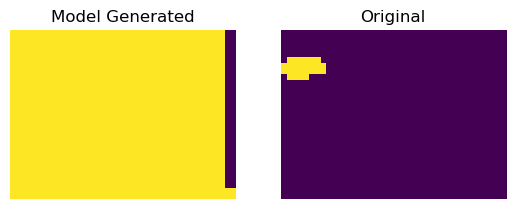

torch.Size([30, 40]) torch.Size([30, 40])


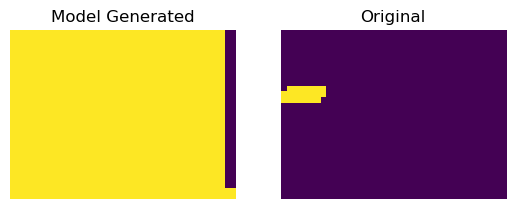

Epoch 35:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0337, 0.0091], device='cuda:0')
IDX: 3807, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


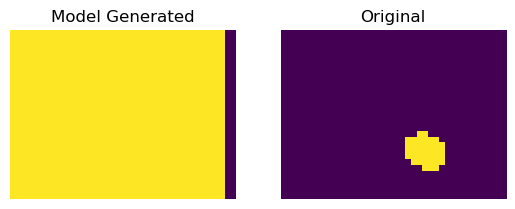

torch.Size([30, 40]) torch.Size([30, 40])


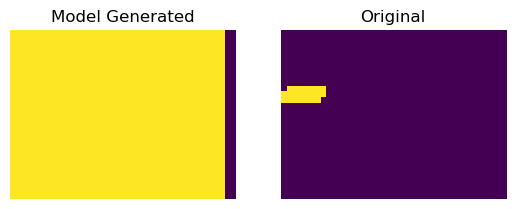

Epoch 36:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0349, 0.0091], device='cuda:0')
IDX: 3316, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


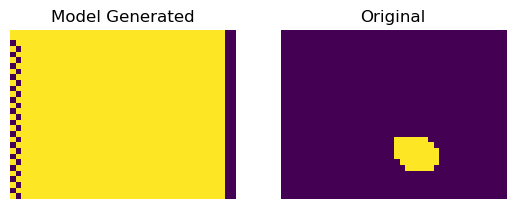

torch.Size([30, 40]) torch.Size([30, 40])


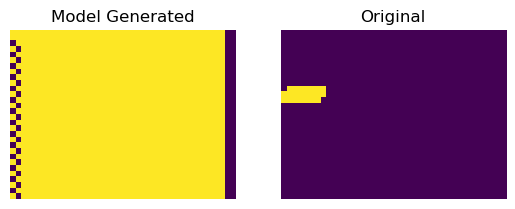

Epoch 37:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 3275, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


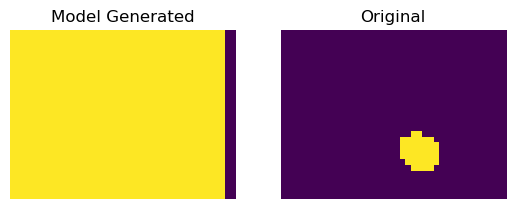

torch.Size([30, 40]) torch.Size([30, 40])


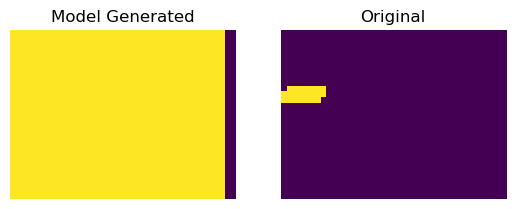

Epoch 38:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 1178, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


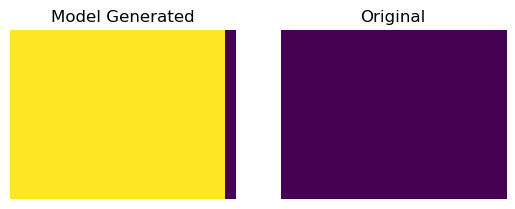

torch.Size([30, 40]) torch.Size([30, 40])


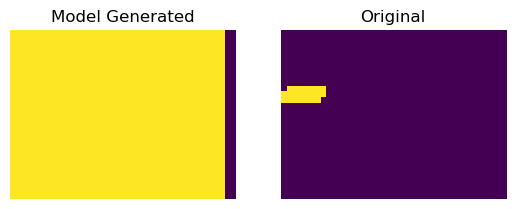

Epoch 39:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 3428, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


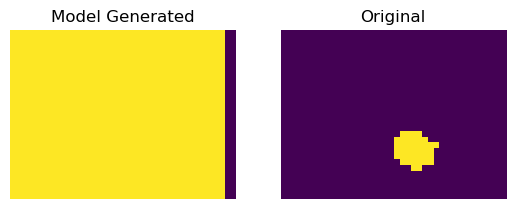

torch.Size([30, 40]) torch.Size([30, 40])


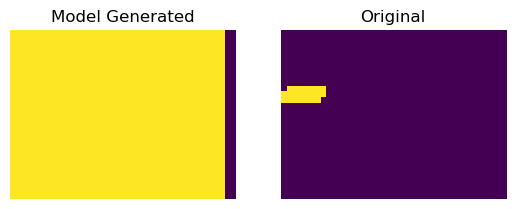

Epoch 40:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 885, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


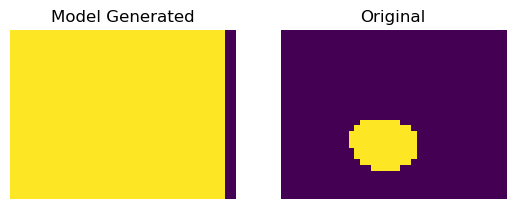

torch.Size([30, 40]) torch.Size([30, 40])


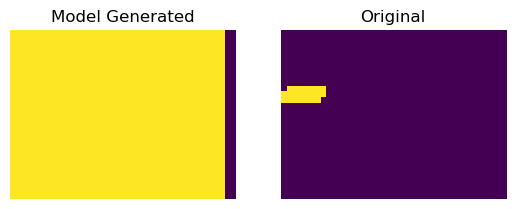

Epoch 41:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 2878, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


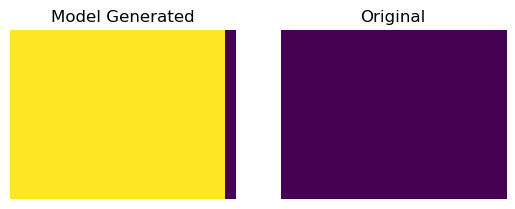

torch.Size([30, 40]) torch.Size([30, 40])


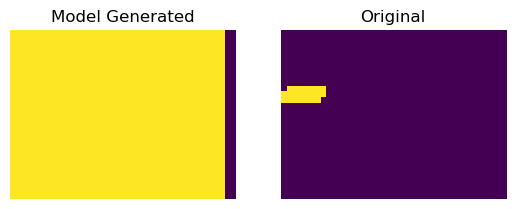

Epoch 42:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 489, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


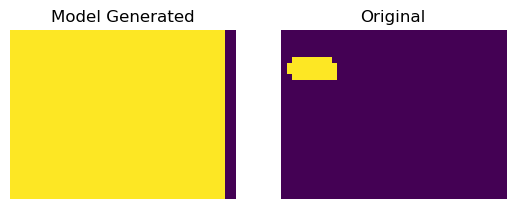

torch.Size([30, 40]) torch.Size([30, 40])


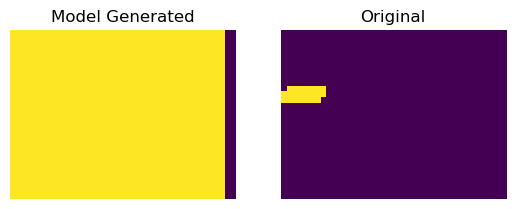

Epoch 43:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 2236, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


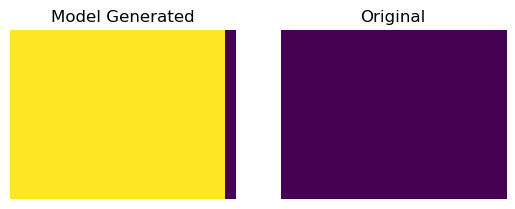

torch.Size([30, 40]) torch.Size([30, 40])


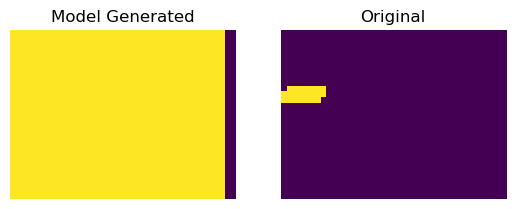

Epoch 44:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0340, 0.0091], device='cuda:0')
IDX: 2279, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


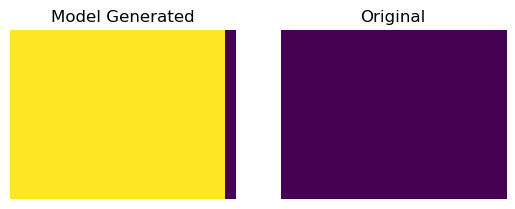

torch.Size([30, 40]) torch.Size([30, 40])


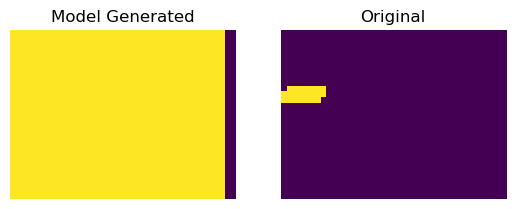

Epoch 45:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 2189, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


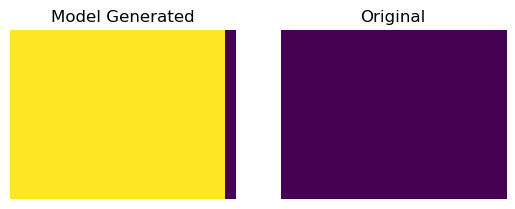

torch.Size([30, 40]) torch.Size([30, 40])


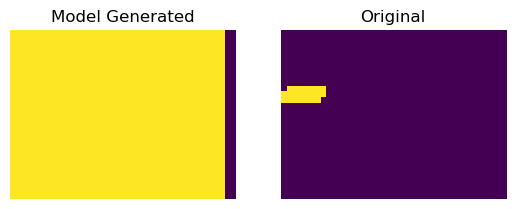

Epoch 46:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0325, 0.0091], device='cuda:0')
IDX: 2133, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


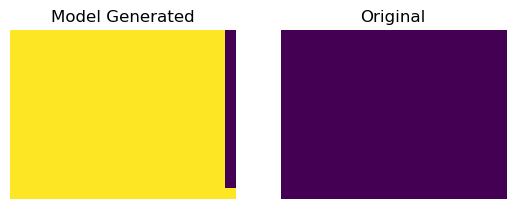

torch.Size([30, 40]) torch.Size([30, 40])


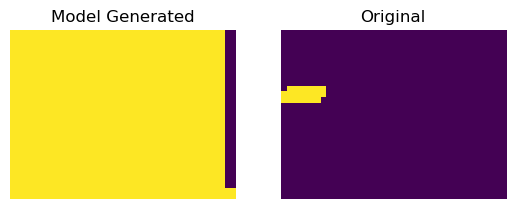

Epoch 47:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 11, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


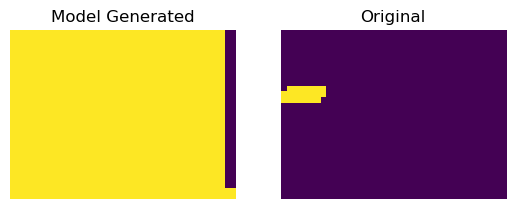

torch.Size([30, 40]) torch.Size([30, 40])


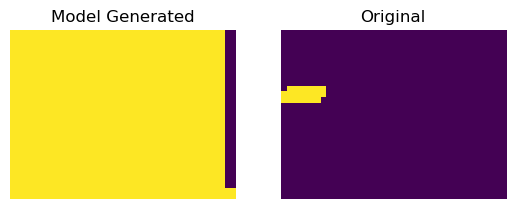

Epoch 48:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 148, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


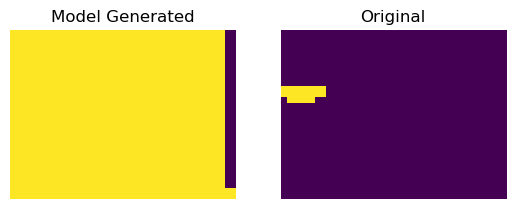

torch.Size([30, 40]) torch.Size([30, 40])


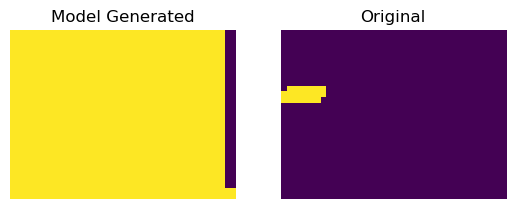

Epoch 49:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0337, 0.0091], device='cuda:0')
IDX: 2756, time_step: 0
torch.Size([30, 40]) torch.Size([30, 40])


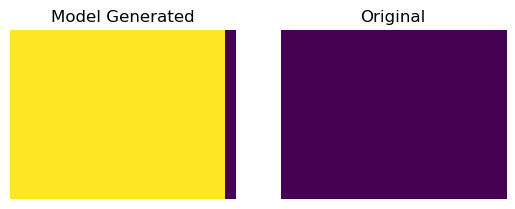

torch.Size([30, 40]) torch.Size([30, 40])


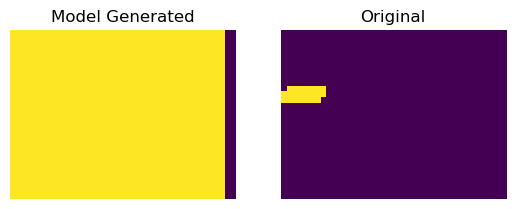

Epoch 50:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 1555, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


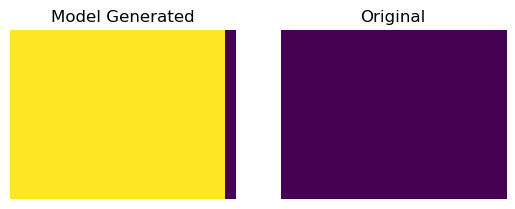

torch.Size([30, 40]) torch.Size([30, 40])


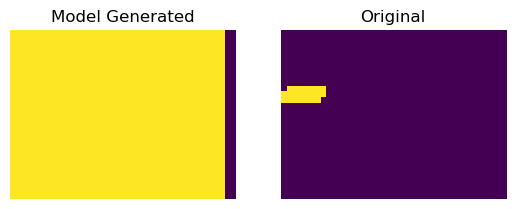

Epoch 51:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0341, 0.0091], device='cuda:0')
IDX: 3750, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


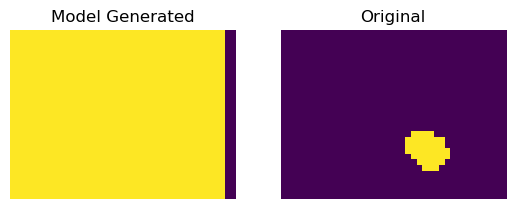

torch.Size([30, 40]) torch.Size([30, 40])


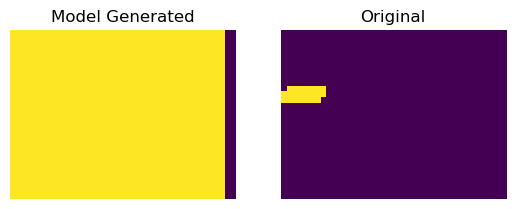

Epoch 52:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0340, 0.0091], device='cuda:0')
IDX: 3654, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


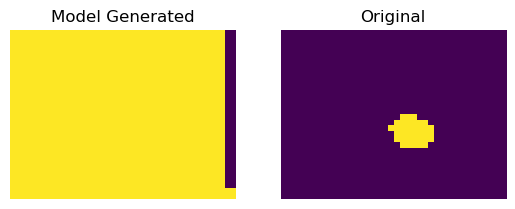

torch.Size([30, 40]) torch.Size([30, 40])


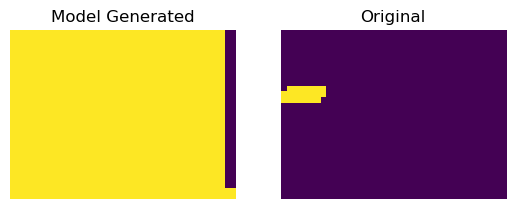

Epoch 53:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0328, 0.0091], device='cuda:0')
IDX: 72, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


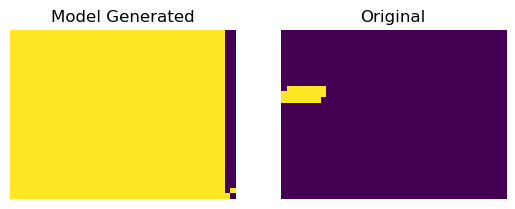

torch.Size([30, 40]) torch.Size([30, 40])


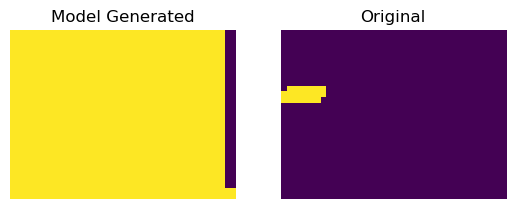

Epoch 54:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0326, 0.0091], device='cuda:0')
IDX: 284, time_step: 2
torch.Size([30, 40]) torch.Size([30, 40])


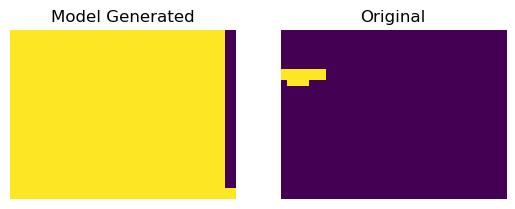

torch.Size([30, 40]) torch.Size([30, 40])


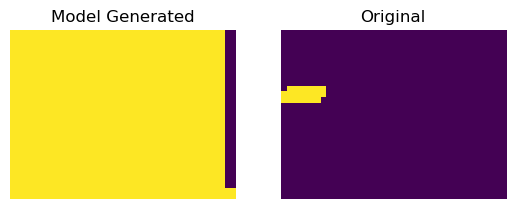

Epoch 55:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 3648, time_step: 2
torch.Size([30, 40]) torch.Size([30, 40])


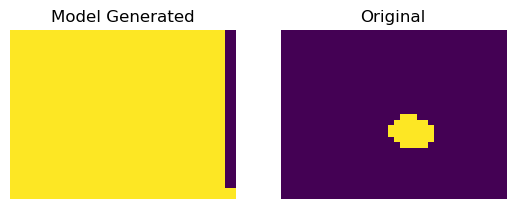

torch.Size([30, 40]) torch.Size([30, 40])


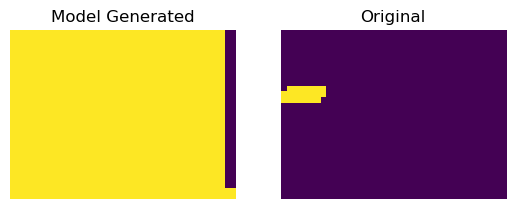

Epoch 56:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 3561, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


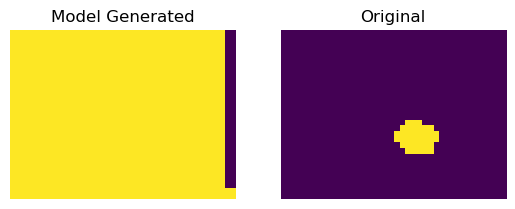

torch.Size([30, 40]) torch.Size([30, 40])


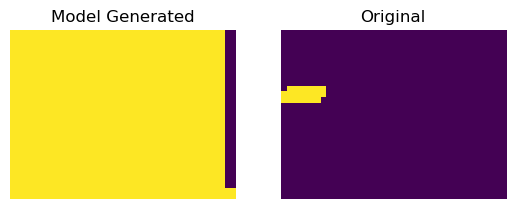

Epoch 57:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 3491, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


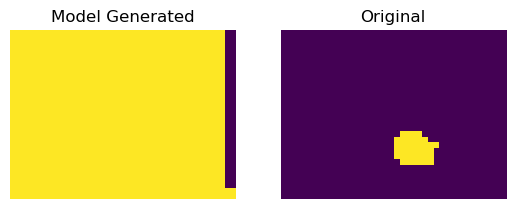

torch.Size([30, 40]) torch.Size([30, 40])


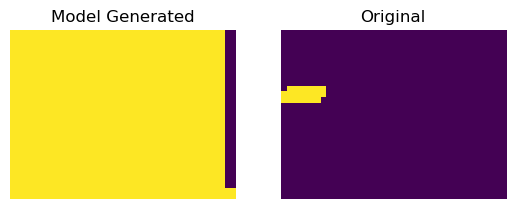

Epoch 58:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0093], device='cuda:0')
IDX: 269, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


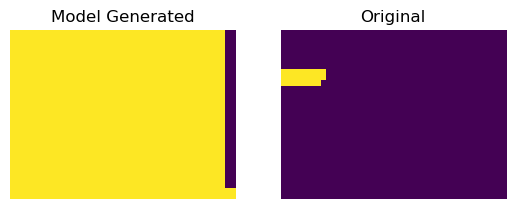

torch.Size([30, 40]) torch.Size([30, 40])


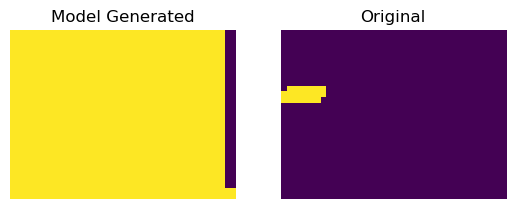

Epoch 59:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 2481, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


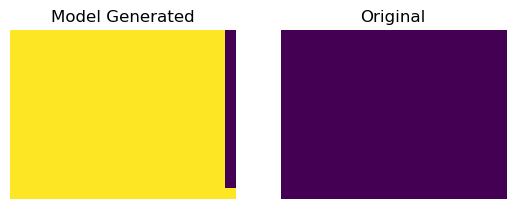

torch.Size([30, 40]) torch.Size([30, 40])


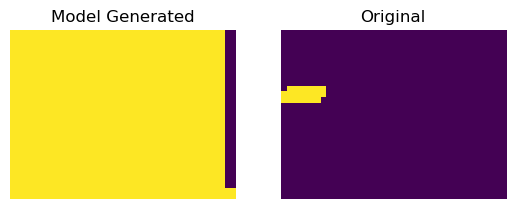

Epoch 60:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 1087, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


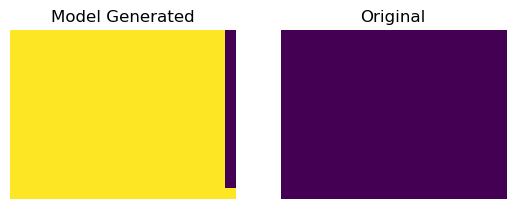

torch.Size([30, 40]) torch.Size([30, 40])


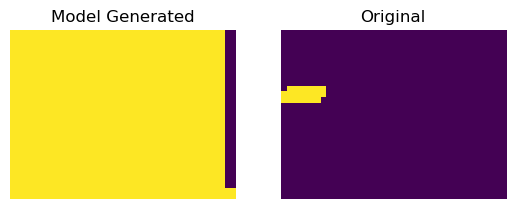

Epoch 61:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 582, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


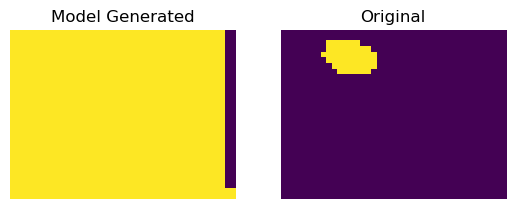

torch.Size([30, 40]) torch.Size([30, 40])


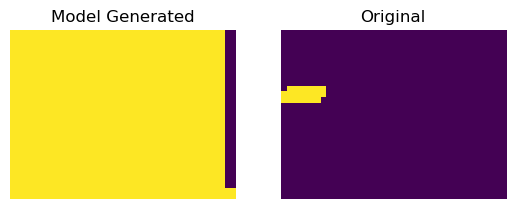

Epoch 62:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 277, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


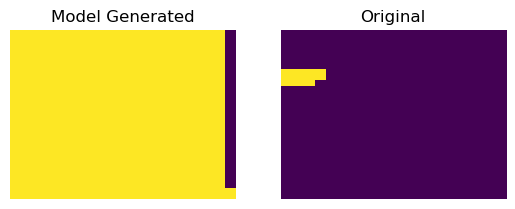

torch.Size([30, 40]) torch.Size([30, 40])


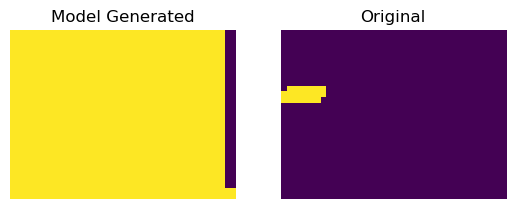

Epoch 63:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 867, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


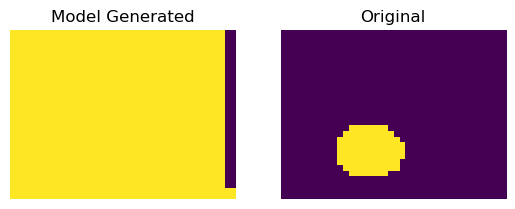

torch.Size([30, 40]) torch.Size([30, 40])


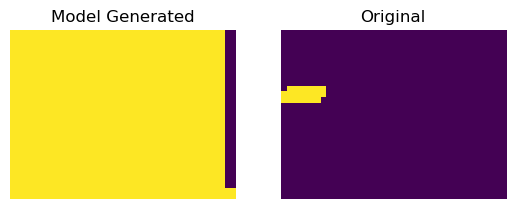

Epoch 64:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0324, 0.0091], device='cuda:0')
IDX: 3507, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


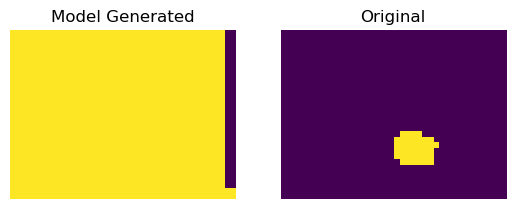

torch.Size([30, 40]) torch.Size([30, 40])


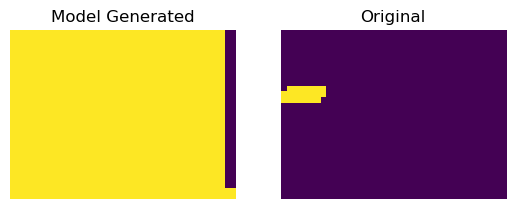

Epoch 65:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.4313, 0.5582], device='cuda:0')
IDX: 268, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


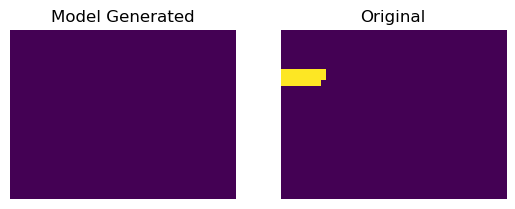

torch.Size([30, 40]) torch.Size([30, 40])


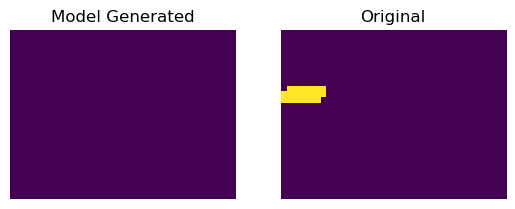

Epoch 66:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0984, 0.5251], device='cuda:0')
IDX: 368, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


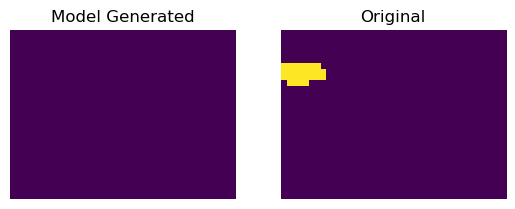

torch.Size([30, 40]) torch.Size([30, 40])


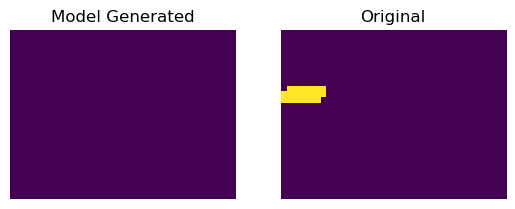

Epoch 67:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0510, 0.5123], device='cuda:0')
IDX: 1402, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


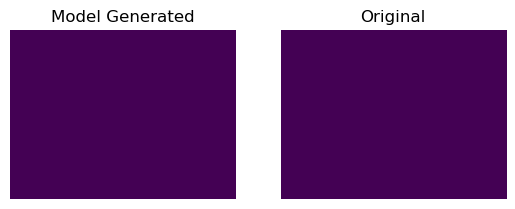

torch.Size([30, 40]) torch.Size([30, 40])


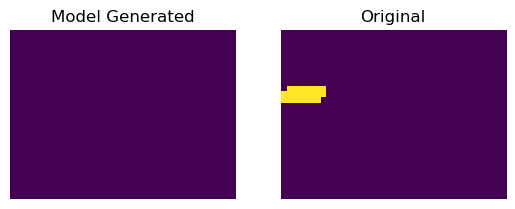

Epoch 68:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.0467, 0.5119], device='cuda:0')
IDX: 2841, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


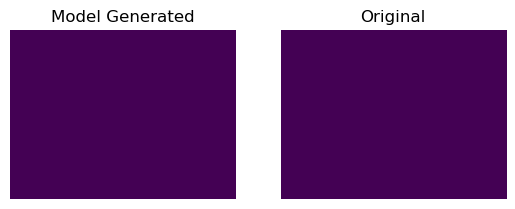

torch.Size([30, 40]) torch.Size([30, 40])


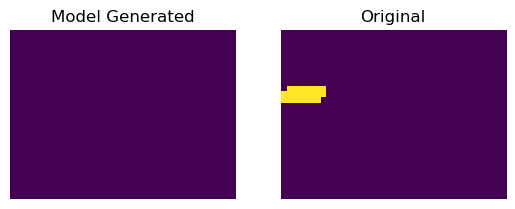

Epoch 69:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.1061, 0.5240], device='cuda:0')
IDX: 3809, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


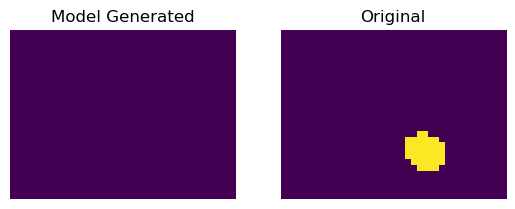

torch.Size([30, 40]) torch.Size([30, 40])


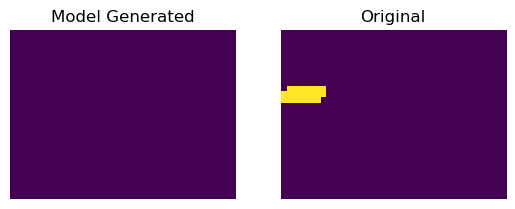

Epoch 70:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.1736, 0.5506], device='cuda:0')
IDX: 3169, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


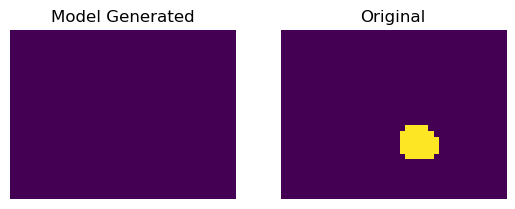

torch.Size([30, 40]) torch.Size([30, 40])


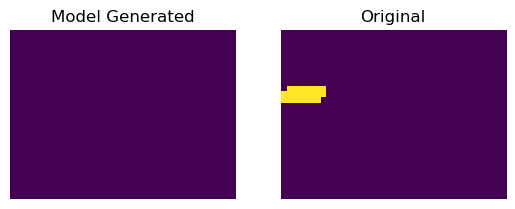

Epoch 71:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9661, 0.9664], device='cuda:0')
IDX: 1631, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


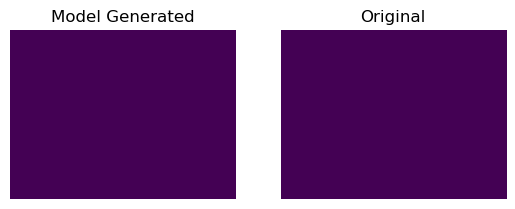

torch.Size([30, 40]) torch.Size([30, 40])


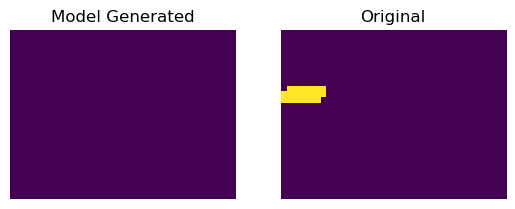

Epoch 72:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9666, 0.9666], device='cuda:0')
IDX: 2974, time_step: 2
torch.Size([30, 40]) torch.Size([30, 40])


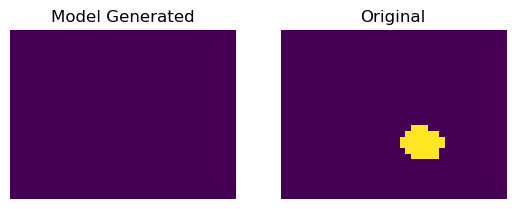

torch.Size([30, 40]) torch.Size([30, 40])


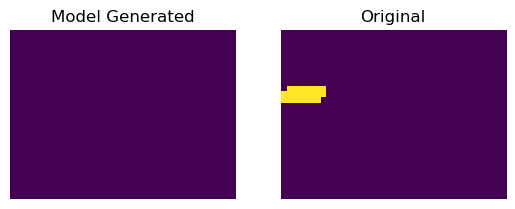

Epoch 73:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9667, 0.9667], device='cuda:0')
IDX: 1305, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


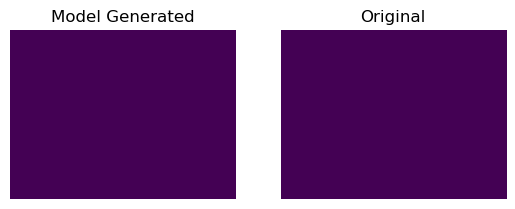

torch.Size([30, 40]) torch.Size([30, 40])


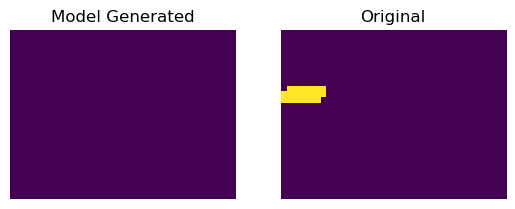

Epoch 74:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9663, 0.9663], device='cuda:0')
IDX: 413, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


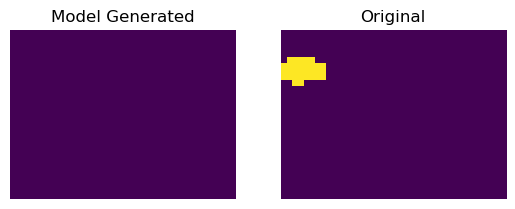

torch.Size([30, 40]) torch.Size([30, 40])


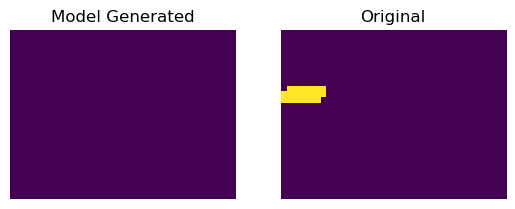

Epoch 75:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9635, 0.9637], device='cuda:0')
IDX: 3741, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


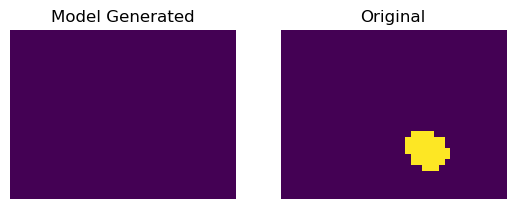

torch.Size([30, 40]) torch.Size([30, 40])


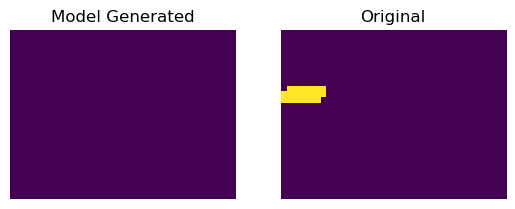

Epoch 76:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9624, 0.9625], device='cuda:0')
IDX: 219, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


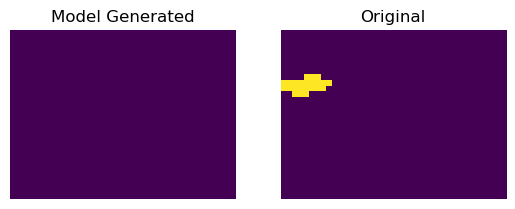

torch.Size([30, 40]) torch.Size([30, 40])


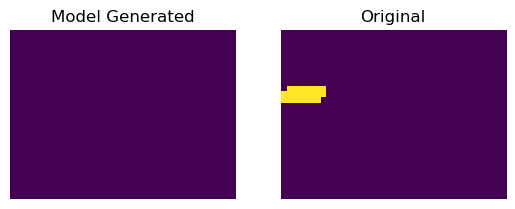

Epoch 77:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9050, 0.9105], device='cuda:0')
IDX: 2685, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


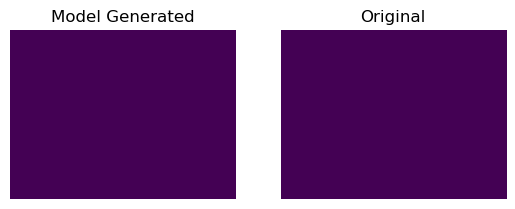

torch.Size([30, 40]) torch.Size([30, 40])


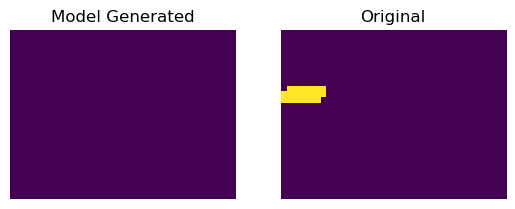

Epoch 78:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9031, 0.9088], device='cuda:0')
IDX: 2931, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


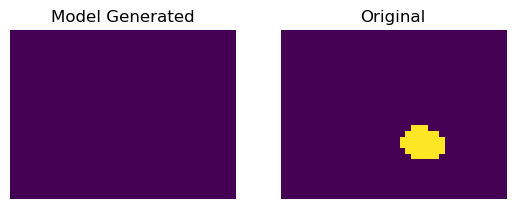

torch.Size([30, 40]) torch.Size([30, 40])


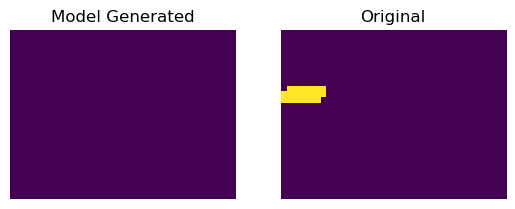

Epoch 79:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.8992, 0.9055], device='cuda:0')
IDX: 3638, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


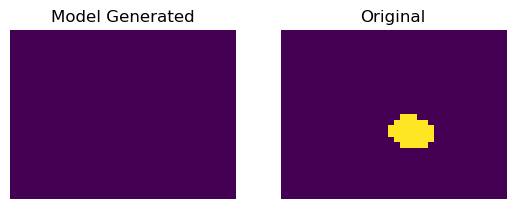

torch.Size([30, 40]) torch.Size([30, 40])


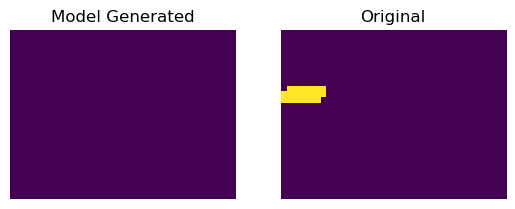

Epoch 80:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9046, 0.9101], device='cuda:0')
IDX: 2527, time_step: 2
torch.Size([30, 40]) torch.Size([30, 40])


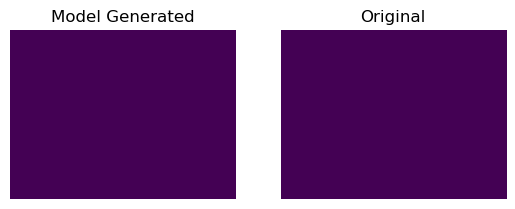

torch.Size([30, 40]) torch.Size([30, 40])


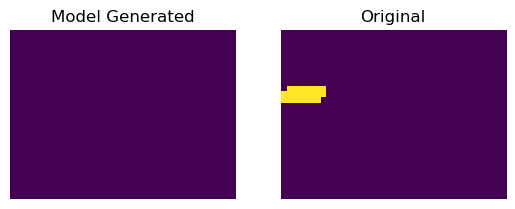

Epoch 81:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9046, 0.9101], device='cuda:0')
IDX: 3743, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


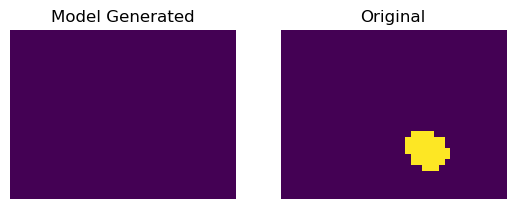

torch.Size([30, 40]) torch.Size([30, 40])


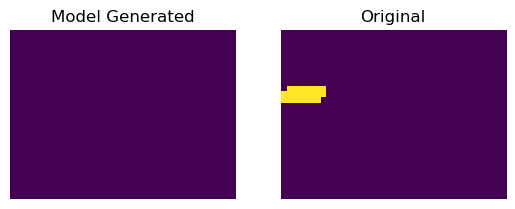

Epoch 82:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9046, 0.9101], device='cuda:0')
IDX: 3156, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


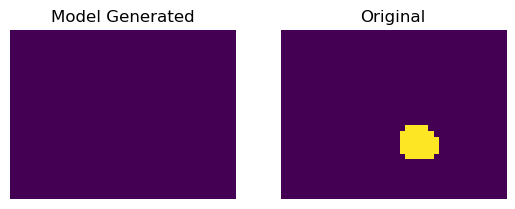

torch.Size([30, 40]) torch.Size([30, 40])


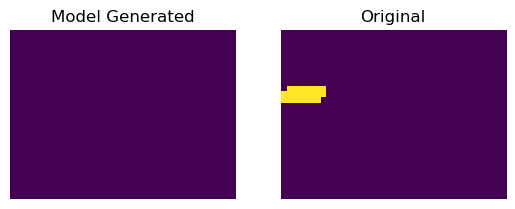

Epoch 83:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9027, 0.9086], device='cuda:0')
IDX: 3044, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


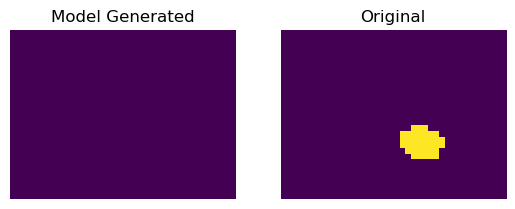

torch.Size([30, 40]) torch.Size([30, 40])


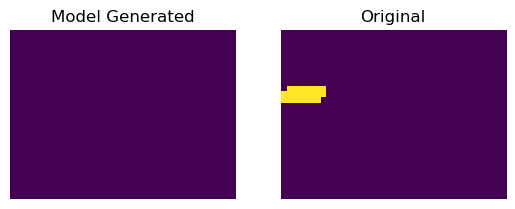

Epoch 84:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9046, 0.9101], device='cuda:0')
IDX: 2004, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


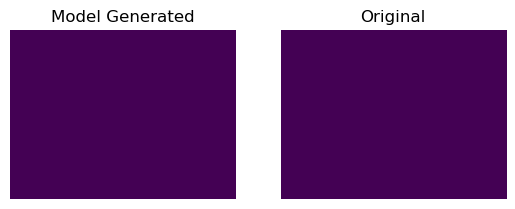

torch.Size([30, 40]) torch.Size([30, 40])


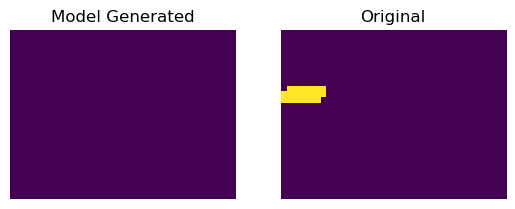

Epoch 85:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9057, 0.9112], device='cuda:0')
IDX: 1575, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


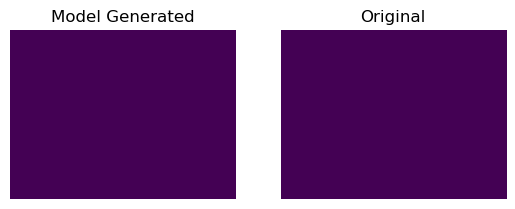

torch.Size([30, 40]) torch.Size([30, 40])


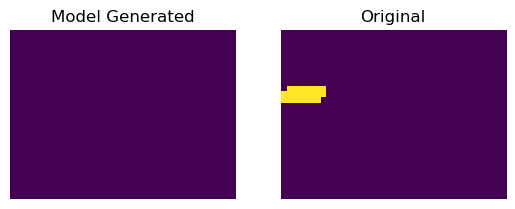

Epoch 86:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9634, 0.9635], device='cuda:0')
IDX: 2992, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


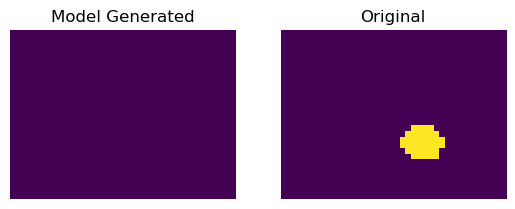

torch.Size([30, 40]) torch.Size([30, 40])


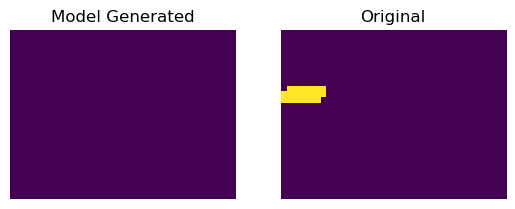

Epoch 87:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9634, 0.9635], device='cuda:0')
IDX: 2435, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


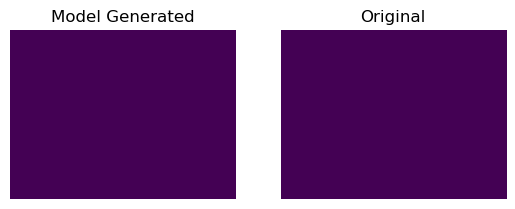

torch.Size([30, 40]) torch.Size([30, 40])


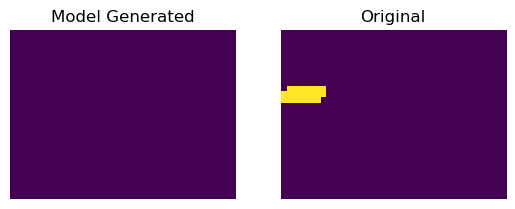

Epoch 88:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9645, 0.9645], device='cuda:0')
IDX: 443, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


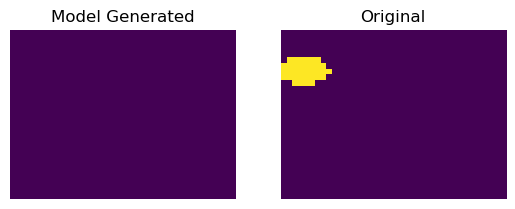

torch.Size([30, 40]) torch.Size([30, 40])


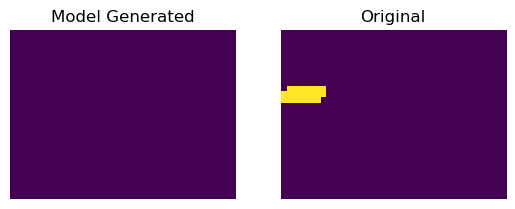

Epoch 89:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9662, 0.9661], device='cuda:0')
IDX: 2671, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


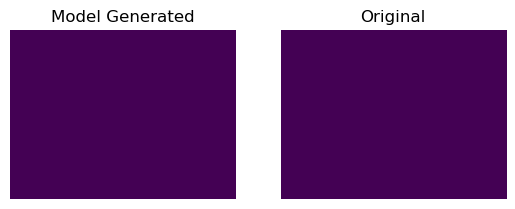

torch.Size([30, 40]) torch.Size([30, 40])


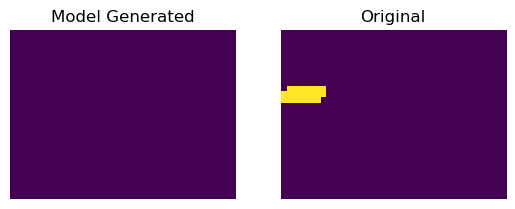

Epoch 90:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 3341, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


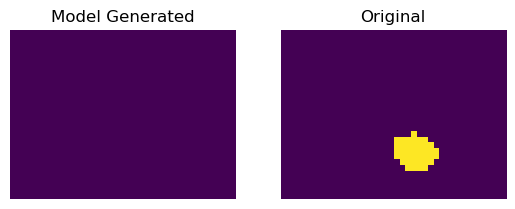

torch.Size([30, 40]) torch.Size([30, 40])


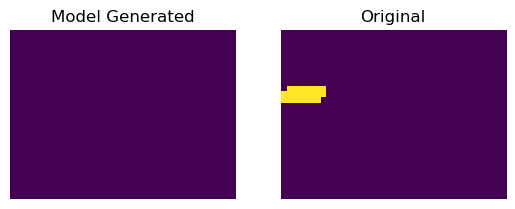

Epoch 91:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 774, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


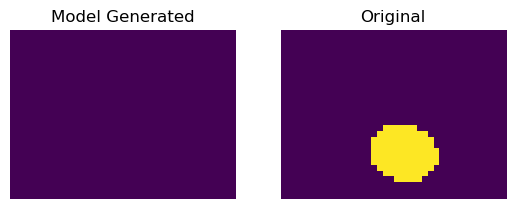

torch.Size([30, 40]) torch.Size([30, 40])


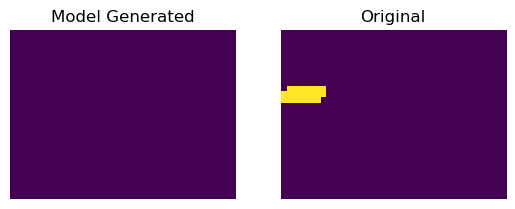

Epoch 92:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 794, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


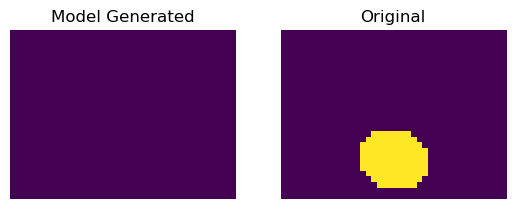

torch.Size([30, 40]) torch.Size([30, 40])


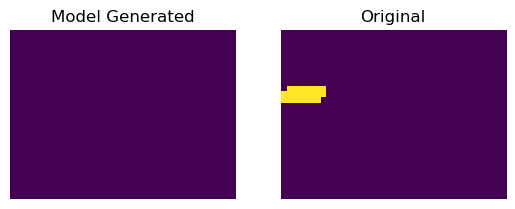

Epoch 93:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 1060, time_step: 0
torch.Size([30, 40]) torch.Size([30, 40])


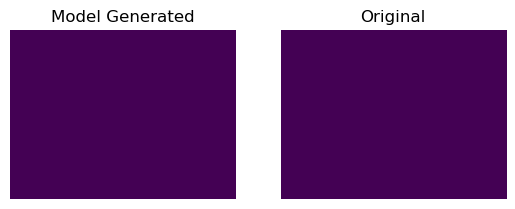

torch.Size([30, 40]) torch.Size([30, 40])


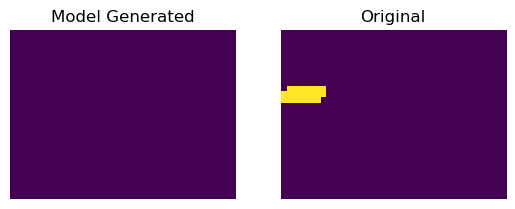

Epoch 94:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 3665, time_step: 0
torch.Size([30, 40]) torch.Size([30, 40])


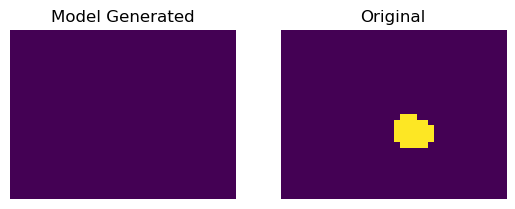

torch.Size([30, 40]) torch.Size([30, 40])


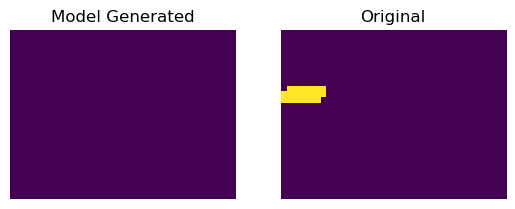

Epoch 95:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 3662, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


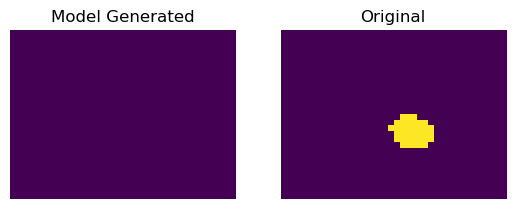

torch.Size([30, 40]) torch.Size([30, 40])


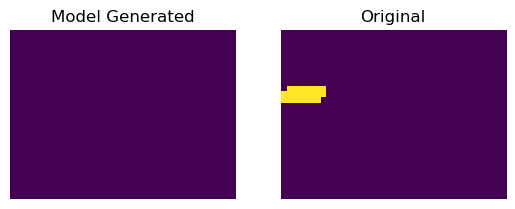

Epoch 96:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 392, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


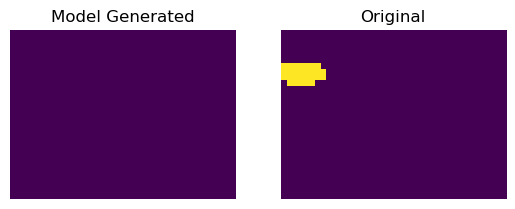

torch.Size([30, 40]) torch.Size([30, 40])


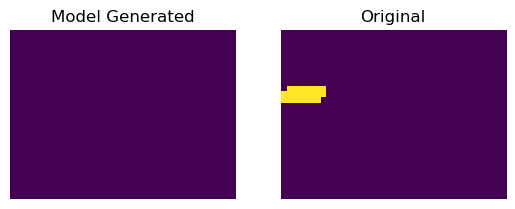

Epoch 97:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 1727, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


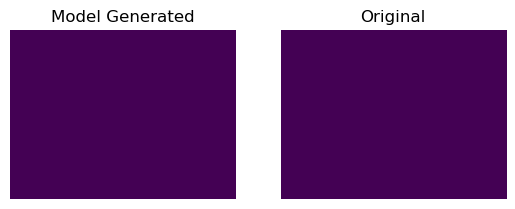

torch.Size([30, 40]) torch.Size([30, 40])


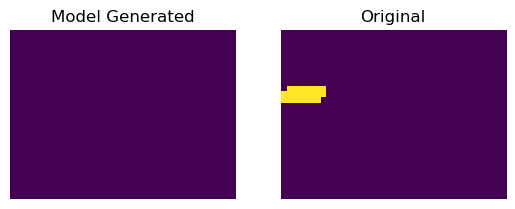

Epoch 98:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 283, time_step: 4
torch.Size([30, 40]) torch.Size([30, 40])


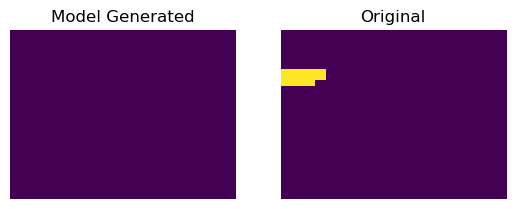

torch.Size([30, 40]) torch.Size([30, 40])


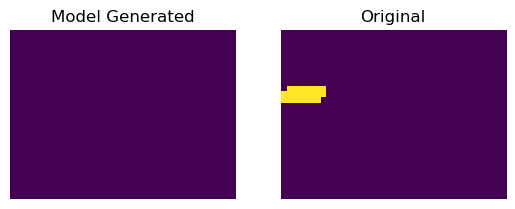

Epoch 99:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 2490, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


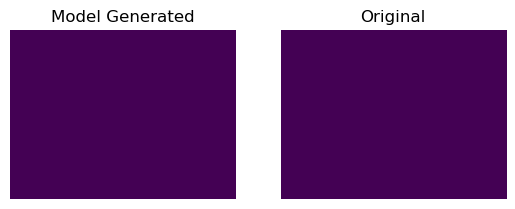

torch.Size([30, 40]) torch.Size([30, 40])


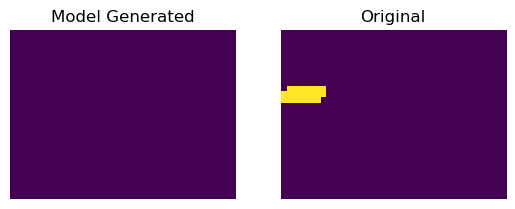

Epoch 100:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 1080, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


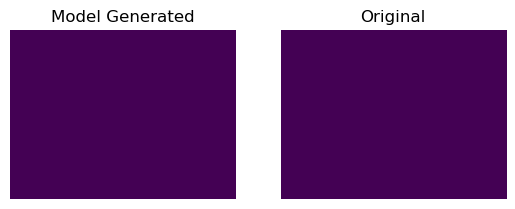

torch.Size([30, 40]) torch.Size([30, 40])


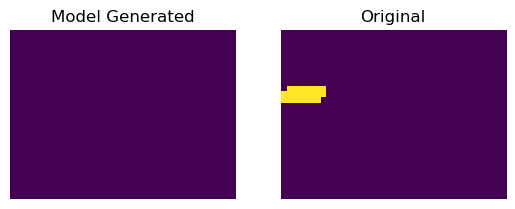

Epoch 101:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 1682, time_step: 6
torch.Size([30, 40]) torch.Size([30, 40])


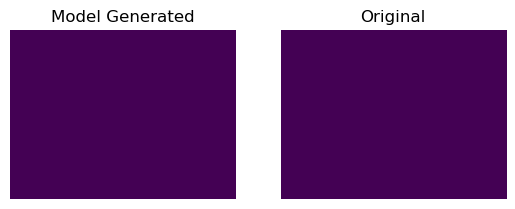

torch.Size([30, 40]) torch.Size([30, 40])


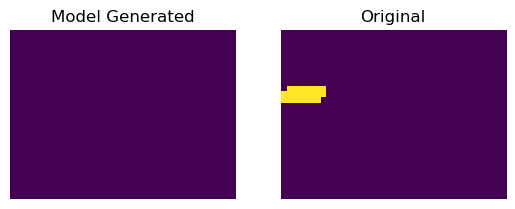

Epoch 102:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 3891, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


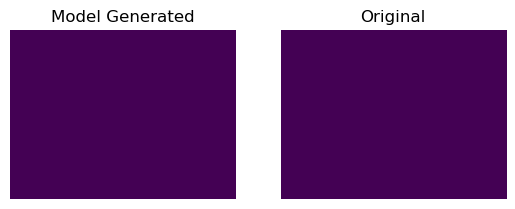

torch.Size([30, 40]) torch.Size([30, 40])


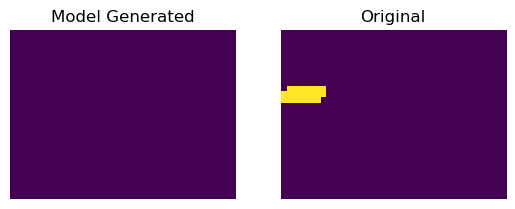

Epoch 103:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 2808, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


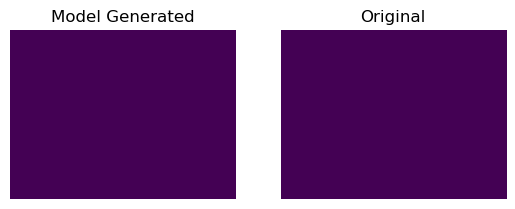

torch.Size([30, 40]) torch.Size([30, 40])


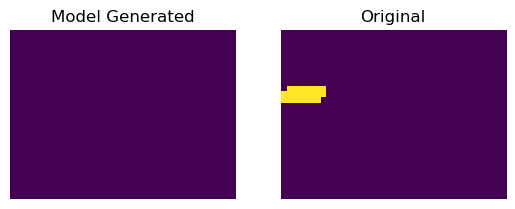

Epoch 104:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 1026, time_step: 5
torch.Size([30, 40]) torch.Size([30, 40])


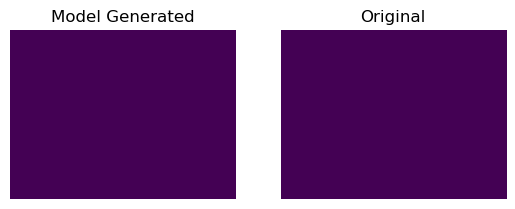

torch.Size([30, 40]) torch.Size([30, 40])


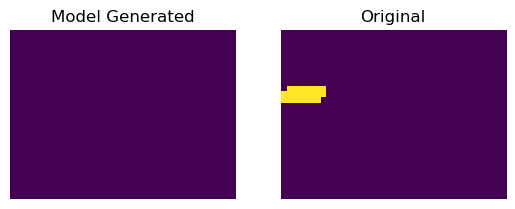

Epoch 105:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 2584, time_step: 7
torch.Size([30, 40]) torch.Size([30, 40])


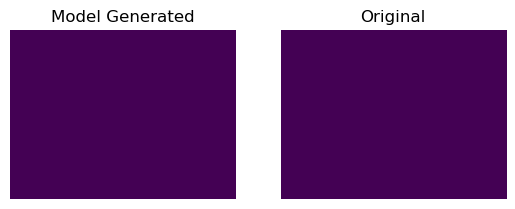

torch.Size([30, 40]) torch.Size([30, 40])


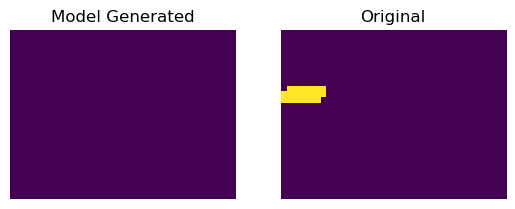

Epoch 106:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 3914, time_step: 0
torch.Size([30, 40]) torch.Size([30, 40])


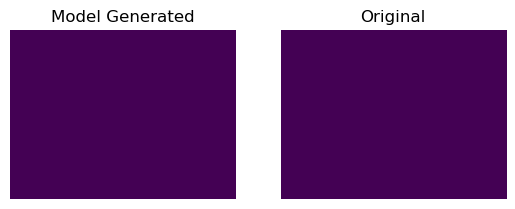

torch.Size([30, 40]) torch.Size([30, 40])


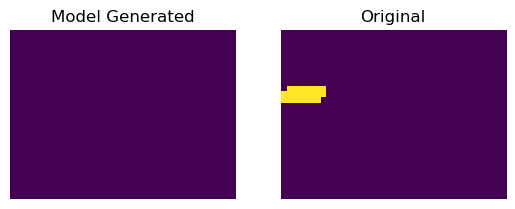

Epoch 107:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 1697, time_step: 1
torch.Size([30, 40]) torch.Size([30, 40])


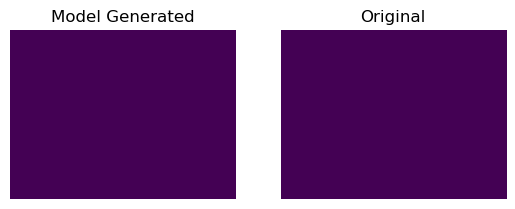

torch.Size([30, 40]) torch.Size([30, 40])


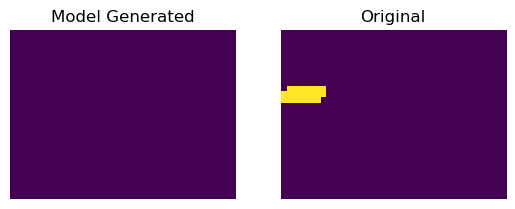

Epoch 108:   0%|          | 0/980 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9668, 0.9668], device='cuda:0')
IDX: 2380, time_step: 3
torch.Size([30, 40]) torch.Size([30, 40])


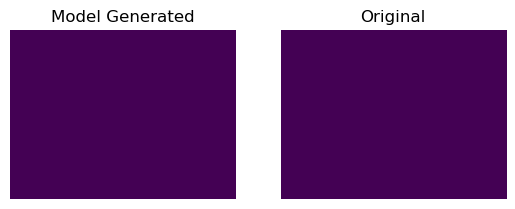

torch.Size([30, 40]) torch.Size([30, 40])


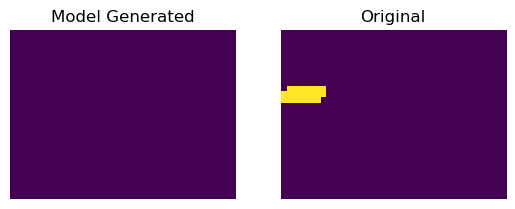

Epoch 109:   0%|          | 0/980 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:
metric = MulticlassJaccardIndex(num_classes=num_classes_in_output, average='none').to(device)
for epoch in range(num_epochs):
    train_batch = tqdm(iter(trainloader), desc=f"Epoch {epoch}")

    batch_IoUs = None
    batch_len = len(train_batch)
    for data, masks in train_batch:
        data = data.to(device).to(torch.float) # Data currently in batch_size, num_steps, Channels, H, W
        masks = masks.to(device)

        model.train()
        spk_rec, mem_rec = model(data)
        
        step_IoU_sum = None
        # print(mem_rec.shape)
        # print(masks.shape)

        loss_val = loss_fn(spk_rec, masks.to(torch.long))
        for step in range(num_bins_per_frame):
           # loss_val += loss_fn(mem_rec[step], masks.to(torch.long))
            
            preds = spk_rec[step].to(torch.int)
            #print(preds.shape)
            targets = masks.to(torch.int64)

            targets = torch.nn.functional.one_hot(targets, num_classes=num_classes_in_output).transpose(1, 3).transpose(2, 3) # IoU metric wants one-hot, while loss does not.

            #print(preds.shape, targets.shape)
            IoU = metric(preds, targets) # Makes it (1, num_classes_in_dataset) so that it can be catted properly

            if step_IoU_sum is None:
                step_IoU_sum = IoU
            else:
                step_IoU_sum = torch.add(step_IoU_sum, IoU)
                
        
        mean_step_IoUs = step_IoU_sum / num_bins_per_frame
        #print(step_IoU_sum.shape, mean_step_IoUs)

        if batch_IoUs is None:
            batch_IoUs = mean_step_IoUs
        else:
            batch_IoUs = torch.add(batch_IoUs, mean_step_IoUs)

        #print(batch_IoUs.shape)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    
    mean_batch_IoUs = batch_IoUs / batch_len
    # print(batch_IoUs.shape, mean_batch_IoUs.shape)
    print(f"Epoch Average IoU Per Class: {mean_batch_IoUs}")

    torch.save(model, "./current_model.pth")
    gc.collect()
    
    idx = int(np.random.randint(low=0, high=len(dataset), size=1))
    time_step = int(np.random.randint(low=0, high=num_bins_per_frame, size=1))
    print(f"IDX: {idx}, time_step: {time_step}")
    _, _ = compare_masks(dataset, index=idx, time_step=time_step)
    _, _ = compare_masks(dataset, index=0, time_step=0)

# 319: 
/home/user/mambaforge/envs/snn-gpu/lib/python3.10/site-packages/tonic/functional/to_voxel_grid.py:25: RuntimeWarning: invalid value encountered in divide
  n_time_bins
/home/user/mambaforge/envs/snn-gpu/lib/python3.10/site-packages/tonic/functional/to_voxel_grid.py:34: RuntimeWarning: invalid value encountered in cast
  tis = ts.astype(int)

# 2164


In [ ]:
# for i in range(0, len(dataset)):
#     for timestep in range(0, num_bins_per_frame):
#         out_mask, true_mask = compare_masks(dataset, index=i, time_step=timestep, showonlydiff=True)

In [ ]:
out_mask, true_mask = compare_masks(dataset, index=0, time_step=0)

In [ ]:
m = MultilabelJaccardIndex(num_labels=num_classes_in_dataset, average='macro')

In [ ]:
test = torch.zeros(1, num_classes_in_dataset, 2, 2) #480, 640)
test2 = torch.zeros(1, num_classes_in_dataset, 2, 2) #, 480, 640)
test.shape

In [ ]:
test[0][1][0][0] = 1
test2[0][1][0] = 1
#test2[0][0] = 0

In [ ]:
test, test2

In [ ]:
m(test.to(torch.int), test2.to(torch.int))

In [ ]:
import sparseconvnet as scn

In [ ]:
test = scn.SubmanifoldConvolution(dimension=2, nIn=1, nOut=2, filter_size=3, bias=False)

In [ ]:
bins, mask = dataset[1000]

In [ ]:
test(bins)